In [36]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import duckdb
from scipy import stats

sns.set_style("whitegrid")
from scikit_posthocs import posthoc_dunn

---
### Host range

In [37]:
df = pl.read_csv(
    "../crispr_search/plasmid_host_taxonomy_consolidated_all_possible_hosts_final_derep.tsv",
    separator="\t",
)

df.head()

Plasmid,host,method
str,str,str
"""2088090014|GPI…","""d__Bacteria;p_…","""iphop-blast"""
"""2088090014|GPI…","""d__Bacteria;p_…","""iphop-blast"""
"""2088090014|GPI…","""d__Bacteria;p_…","""iphop-blast"""
"""2088090014|GPI…","""d__Bacteria;p_…","""iphop-blast"""
"""2088090015|GPI…","""d__Bacteria;p_…","""iphop-blast"""


In [38]:
df = df.with_columns(
    phylum=pl.col("host").str.split(";").list.get(1),
    cclass=pl.col("host").str.split(";").list.get(2),
    order=pl.col("host").str.split(";").list.get(3),
    family=pl.col("host").str.split(";").list.get(4),
    genus=pl.col("host").str.split(";").list.get(5),
    species=pl.col("host").str.split(";").list.get(6),
)

df.head()

Plasmid,host,method,phylum,cclass,order,family,genus,species
str,str,str,str,str,str,str,str,str
"""2088090014|GPI…","""d__Bacteria;p_…","""iphop-blast""","""p__Pseudomonad…","""c__Alphaproteo…","""o__Rhizobiales…","""f__Methylolige…","""g__Methylocean…","""s__Methylocean…"
"""2088090014|GPI…","""d__Bacteria;p_…","""iphop-blast""","""p__Pseudomonad…","""c__Alphaproteo…","""o__Rhizobiales…","""f__Methylolige…","""g__Methylocean…",null
"""2088090014|GPI…","""d__Bacteria;p_…","""iphop-blast""","""p__Acidobacter…","""c__Vicinamibac…","""o__Vicinamibac…","""f__UBA2999""","""g__2-02-FULL-6…",null
"""2088090014|GPI…","""d__Bacteria;p_…","""iphop-blast""","""p__Acidobacter…","""c__Vicinamibac…","""o__Vicinamibac…","""f__UBA2999""","""g__2-02-FULL-6…","""s__2-02-FULL-6…"
"""2088090015|GPI…","""d__Bacteria;p_…","""iphop-blast""","""p__Actinomycet…","""c__Thermoleoph…","""o__Gaiellales""","""f__Gaiellaceae…","""g__GMQP-bins7""",null


In [39]:
df = df.unique(subset=["Plasmid", "order"])

In [40]:
import pandas as pd
import plotly.express as px

# Sample data

df1 = df.to_pandas()
agg_df = df1.groupby(["phylum", "order"]).size().reset_index(name="count")

# Group small phyla into "Other"
phylum_counts = agg_df.groupby("phylum")["count"].sum().reset_index()
phylum_counts["phylum_grouped"] = phylum_counts.apply(
    lambda row: row["phylum"] if row["count"] >= 3000 else "Other", axis=1
)
agg_df = agg_df.merge(phylum_counts[["phylum", "phylum_grouped"]], on="phylum")

# Group small orders into "Other" within each phylum
agg_df["order_grouped"] = agg_df.apply(
    lambda row: row["order"] if row["count"] >= 500 else "Other", axis=1
)

# Re-aggregate counts with grouped phyla and orders
grouped_df = (
    agg_df.groupby(["phylum_grouped", "order_grouped"])
    .agg({"count": "sum"})
    .reset_index()
)


# Create the sunburst chart
fig = px.sunburst(
    grouped_df,
    path=["phylum_grouped", "order_grouped"],
    values="count",
    title="Sunburst Chart of Phylum and Order Counts",
)

# fig.write_html("sunburst.html")
fig.write_image("../figures/host_sunburst.pdf")

In [41]:
import pandas as pd
import plotly.express as px

# Sample data

df1 = df.to_pandas()
agg_df = df1.groupby(["phylum", "order"]).size().reset_index(name="count")

# Group small phyla into "Other"
phylum_counts = agg_df.groupby("phylum")["count"].sum().reset_index()
phylum_counts["phylum_grouped"] = phylum_counts.apply(
    lambda row: row["phylum"] if row["count"] >= 3000 else "Other", axis=1
)
agg_df = agg_df.merge(phylum_counts[["phylum", "phylum_grouped"]], on="phylum")

# Group small orders into "Other" within each phylum
agg_df["order_grouped"] = agg_df.apply(
    lambda row: row["order"] if row["count"] >= 500 else "Other", axis=1
)

# Re-aggregate counts with grouped phyla and orders
grouped_df = (
    agg_df.groupby(["phylum_grouped", "order_grouped"])
    .agg({"count": "sum"})
    .reset_index()
)


# Create the sunburst chart
fig = px.sunburst(
    grouped_df,
    path=["phylum_grouped", "order_grouped"],
    values="count",
    title="Sunburst Chart of Phylum and Order Counts",
)

# fig.write_html("sunburst.html")
fig.write_image("../figures/host_sunburst.pdf")

In [42]:
import pandas as pd
import plotly.express as px

# Sample data
df1 = df.to_pandas()
agg_df = df1.groupby(["phylum", "order"]).size().reset_index(name="count")

# Group small phyla into "Other"
phylum_counts = agg_df.groupby("phylum")["count"].sum().reset_index()
phylum_counts["phylum_grouped"] = phylum_counts.apply(
    lambda row: row["phylum"] if row["count"] >= 3000 else "Other", axis=1
)
agg_df = agg_df.merge(phylum_counts[["phylum", "phylum_grouped"]], on="phylum")

# Group small orders into "Other" within each phylum
agg_df["order_grouped"] = agg_df.apply(
    lambda row: row["order"] if row["count"] >= 500 else "Other", axis=1
)

# Re-aggregate counts with grouped phyla and orders
grouped_df = (
    agg_df.groupby(["phylum_grouped", "order_grouped"])
    .agg({"count": "sum"})
    .reset_index()
)

# Create the treemap chart
fig = px.treemap(
    grouped_df,
    path=["phylum_grouped", "order_grouped"],
    values="count",
    title="Treemap of Phylum and Order Counts",
)

# Customize the layout if needed
# fig.update_layout(
#     width=800,
#     height=600,
# )

# Save the figure
fig.write_image("../figures/host_treemap.pdf")


In [43]:
grouped_df

,phylum_grouped,order_grouped,count
0,Other,Other,5103
1,Other,o__Bacillales,1445
2,p__Acidobacteriota,Other,545
3,p__Acidobacteriota,o__Acidoferrales,1109
4,p__Acidobacteriota,o__Bryobacterales,600
5,p__Acidobacteriota,o__Terriglobales,8549
6,p__Actinomycetota,Other,1073
7,p__Actinomycetota,o__Acidimicrobiales,768
8,p__Actinomycetota,o__Actinomycetales,1191
9,p__Actinomycetota,o__Mycobacteriales,2581


In [44]:
df["phylum"].value_counts().sort(by="count", descending=True)

phylum,count
str,u32
"""p__Pseudomonad…",28510
"""p__Actinomycet…",13321
"""p__Acidobacter…",10803
"""p__Bacillota""",1727
"""p__Proteobacte…",1081
"""p__Bacteroidot…",1012
"""p__Cyanobacter…",555
"""p__Actinobacte…",370
"""p__Verrucomicr…",229


In [45]:
con = duckdb.connect("../soil_plasmid.db")
ptus = con.sql("SELECT * FROM ptu_derep").df().set_index("pOTU")
con.close()
ptus.head()

,Representative,Members,Length,oids,Ecosystem Subtype Custom,Ecosystem Subtype,WWF_MHTNAM,Origin,Full_origin
pOTU,,,,,,,,,
pOTU-00000,3300056587|Ga0562382_00532,"3300056587|Ga0562382_00532,3300041809|Ga045567...",187,"3300056587,3300041809,3300056587,3300055278,33...",Peat;Grasslands;Peat;Temperate forest;Peat;Pea...,Peat;Grasslands;Peat;Temperate forest;Peat;Pea...,Tundra;Temperate Conifer Forests;Tundra;Temper...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...
pOTU-00001,3300056791|Ga0562384_00281,"3300056791|Ga0562384_00281,3300054973|Ga049542...",158,"3300056791,3300054973,3300047661,3300051166,33...",Peat;Peat;Peat;Peat;Peat;Peat;Peat;Peat;Peat;P...,Peat;Peat;Peat;Peat;Peat;Peat;Peat;Peat;Peat;P...,Tundra;Tundra;Tundra;Tundra;Tundra;Tundra;Tund...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...
pOTU-00002,3300046709|Ga0495471_0000157,"3300046709|Ga0495471_0000157,3300046788|Ga0495...",105,"3300046709,3300046788,3300046461,3300046811,33...",Agricultural land;Agricultural land;Rhizospher...,Agricultural land;Agricultural land;Rhizospher...,Temperate Conifer Forests;Temperate Conifer Fo...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...
pOTU-00003,3300046559|Ga0495667_0000358,"3300046559|Ga0495667_0000358,3300036401|Ga0373...",98,"3300046559,3300036401,3300046543,3300046724,33...",Rhizosphere;Rhizosphere;Rhizosphere;Agricultur...,Rhizosphere;Rhizosphere;Rhizosphere;Agricultur...,Temperate Conifer Forests;Temperate Conifer Fo...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...
pOTU-00004,3300056834|Ga0562381_00901,"3300056834|Ga0562381_00901,3300056587|Ga056238...",85,"3300056834,3300056587,3300048796,3300048785,33...",Peat;Peat;Peat;Peat;Peat;Temperate forest;Gras...,Peat;Peat;Peat;Peat;Peat;Temperate forest;Gras...,Tundra;Tundra;Tundra;Tundra;Tundra;Temperate C...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...


In [46]:
ptus_per_eco = {}
for ptu in ptus.index:
    for ecosystem in set(ptus.loc[ptu, "Ecosystem Subtype Custom"].split(";")):
        if ecosystem in ptus_per_eco:
            ptus_per_eco[ecosystem] += 1
        else:
            ptus_per_eco[ecosystem] = 1

ptus_per_eco

{'Rhizosphere': 13458,
 'Unclassified': 11705,
 'Temperate forest': 12301,
 'Grasslands': 4986,
 'Peat': 7565,
 'Agricultural land': 6404,
 'Other': 5750,
 'Tropical forest': 1242}

In [47]:
ptus.loc["pOTU-00104"]

Representative                                   3300060709|Ga0597101_0000661
Members                     3300060709|Ga0597101_0000661,3300050234|Ga0506...
Length                                                                     26
oids                        3300060709,3300050234,3300060744,3300042835,33...
Ecosystem Subtype Custom    Other;Agricultural land;Temperate forest;Other...
Ecosystem Subtype           Other;Agricultural land;Temperate forest;Other...
WWF_MHTNAM                  Deserts and Xeric Shrublands;Temperate Grassla...
Origin                                                                   Meta
Full_origin                 Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...
Name: pOTU-00104, dtype: object

This PTU is on all 8 soil classes

In [48]:
ptus_mapping = {}

for i in ptus.index:
    plasmids = ptus.loc[i]["Members"].split(",")
    for plasmid in plasmids:
        ptus_mapping[plasmid] = i

In [49]:
df_envs = pl.read_csv(
    "../env_corr/taxon_countries.tsv", separator="\t", dtypes={"taxon_oid": pl.Utf8}
)
df_envs.head()

taxon_oid,Ecosystem Subtype,Latitude,Longitude,Origin,Isolation Country,Ecosystem Subtype Custom,Plasmid Count,soil_class,bdod (cg/cm³),cec (mmol(c)/kg),cfvo (cm³/dm³),clay (g/kg),nitrogen (cg/kg),ocd (dg/dm³),phh2o (pH*10),sand (g/kg),silt (g/kg),soc (dg/kg),geometry,index_right,ECO_NAME,WWF_REALM,RealmMHT,WWF_REALM2,WWF_MHTNUM,WWF_MHTNAM
str,str,f64,f64,str,str,str,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,f64,str,str,str,str,f64,str
"""3300049023""","""Grasslands""",38.53,-121.78,"""Meta""","""USA""","""Grasslands""",36,"""Luvisols""",152,252,4,267,395,332,69,171,562,335,"""POINT (-121.78…",761.0,"""Great Central …","""NA""","""NA12""","""Nearctic""",12.0,"""Mediterranean …"
"""3300012840""","""Grasslands""",43.07,-89.4,"""Meta""","""USA""","""Grasslands""",21,"""Luvisols""",null,null,null,null,null,null,null,null,null,null,"""POINT (-89.4 4…",187.0,"""Prairie-Forest…","""NA""","""NA4""","""Nearctic""",4.0,"""Temperate Broa…"
"""3300039503""","""Unclassified""",63.88,-149.23,"""Meta""","""USA""","""Unclassified""",3,"""Cambisols""",60,541,112,137,1084,670,49,367,496,2409,"""POINT (-149.23…",734.0,"""Alaska Range""","""NA""","""NA6""","""Nearctic""",6.0,"""Boreal Forests…"
"""3300042005""","""Rhizosphere""",41.2,-97.94,"""Meta""","""USA""","""Rhizosphere""",6,"""Kastanozems""",135,182,3,163,299,377,63,594,242,301,"""POINT (-97.94 …",747.0,"""Central Mixed-…","""NA""","""NA8""","""Nearctic""",8.0,"""Temperate Gras…"
"""3300049265""","""Agricultural l…",38.55,-121.87,"""Meta""","""USA""","""Agricultural l…",1,"""Vertisols""",158,235,8,297,253,330,69,195,508,274,"""POINT (-121.87…",761.0,"""Great Central …","""NA""","""NA12""","""Nearctic""",12.0,"""Mediterranean …"


In [50]:
df = df.with_columns(
    ptu=pl.col("Plasmid").map_elements(lambda x: ptus_mapping.get(x)),
    taxon_oid=pl.col("Plasmid").map_elements(
        lambda x: x.split("|")[0] if "IMGPR" not in x else x.split("_")[2]
    ),
).join(df_envs.drop(["Plasmid Count", "PTU Count"]), on="taxon_oid")
df = df.drop_nulls(subset=["ptu"])
df.head()

Plasmid,host,method,phylum,cclass,order,family,genus,species,ptu,taxon_oid,Ecosystem Subtype,Latitude,Longitude,Origin,Isolation Country,Ecosystem Subtype Custom,soil_class,bdod (cg/cm³),cec (mmol(c)/kg),cfvo (cm³/dm³),clay (g/kg),nitrogen (cg/kg),ocd (dg/dm³),phh2o (pH*10),sand (g/kg),silt (g/kg),soc (dg/kg),geometry,index_right,ECO_NAME,WWF_REALM,RealmMHT,WWF_REALM2,WWF_MHTNUM,WWF_MHTNAM
str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,f64,str,str,str,str,f64,str
"""2162886007|SwR…","""d__Bacteria;p_…","""iphop-blast""","""p__Pseudomonad…","""c__Gammaproteo…","""o__Xanthomonad…","""f__Xanthomonad…","""g__Xanthomonas…",null,"""pOTU-10129""","""2162886007""","""Rhizosphere""",42.79,-84.39,"""Meta""","""USA""","""Rhizosphere""","""Cambisols""",123,270,41,238,1735,412,58,399,363,902,"""POINT (-84.39 …",182.0,"""North Central …","""NA""","""NA4""","""Nearctic""",4.0,"""Temperate Broa…"
"""2162886015|FOa…","""d__Bacteria;p_…","""iphop-blast""","""p__Pseudomonad…","""c__Gammaproteo…","""o__Xanthomonad…","""f__Rhodanobact…","""g__Rhodanobact…","""s__Rhodanobact…","""pOTU-06639""","""2162886015""","""Grasslands""",51.8,-0.37,"""Meta""","""United Kingdom…","""Grasslands""","""Luvisols""",99,300,164,290,637,611,60,310,401,991,"""POINT (-0.37 5…",547.0,"""English Lowlan…","""PA""","""PA4""","""Palearctic""",4.0,"""Temperate Broa…"
"""2162886015|FOa…","""d__Bacteria;p_…","""iphop-blast""","""p__Actinomycet…","""c__Actinomycet…","""o__Streptomyce…","""f__Streptomyce…","""g__Streptomyce…","""s__Streptomyce…","""pOTU-24873""","""2162886015""","""Grasslands""",51.8,-0.37,"""Meta""","""United Kingdom…","""Grasslands""","""Luvisols""",99,300,164,290,637,611,60,310,401,991,"""POINT (-0.37 5…",547.0,"""English Lowlan…","""PA""","""PA4""","""Palearctic""",4.0,"""Temperate Broa…"
"""2162886015|FOa…","""d__Bacteria;p_…","""iphop-blast""","""p__Acidobacter…","""c__Terriglobia…","""o__Terriglobal…","""f__Acidobacter…","""g__JAJXYY01""","""s__JAJXYY01 sp…","""pOTU-06636""","""2162886015""","""Grasslands""",51.8,-0.37,"""Meta""","""United Kingdom…","""Grasslands""","""Luvisols""",99,300,164,290,637,611,60,310,401,991,"""POINT (-0.37 5…",547.0,"""English Lowlan…","""PA""","""PA4""","""Palearctic""",4.0,"""Temperate Broa…"
"""2166559006|FI_…","""d__Bacteria;p_…","""iphop-blast""","""p__Actinomycet…","""c__Actinomycet…","""o__Actinomycet…","""f__Microbacter…","""g__Leifsonia""","""s__Leifsonia s…","""pOTU-24864""","""2166559006""","""Grasslands""",51.8,-0.37,"""Meta""","""United Kingdom…","""Grasslands""","""Luvisols""",99,300,164,290,637,611,60,310,401,991,"""POINT (-0.37 5…",547.0,"""English Lowlan…","""PA""","""PA4""","""Palearctic""",4.0,"""Temperate Broa…"


In [51]:
# separate host column by ;
df_split_host = df.with_columns(
    pl.col("host").str.split(";").list.to_struct(n_field_strategy="max_width")
).unnest("host")
df_split_host.head()

Plasmid,field_0,field_1,field_2,field_3,field_4,field_5,field_6,method,phylum,cclass,order,family,genus,species,ptu,taxon_oid,Ecosystem Subtype,Latitude,Longitude,Origin,Isolation Country,Ecosystem Subtype Custom,soil_class,bdod (cg/cm³),cec (mmol(c)/kg),cfvo (cm³/dm³),clay (g/kg),nitrogen (cg/kg),ocd (dg/dm³),phh2o (pH*10),sand (g/kg),silt (g/kg),soc (dg/kg),geometry,index_right,ECO_NAME,WWF_REALM,RealmMHT,WWF_REALM2,WWF_MHTNUM,WWF_MHTNAM
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,f64,str,str,str,str,f64,str
"""2162886007|SwR…","""d__Bacteria""","""p__Pseudomonad…","""c__Gammaproteo…","""o__Xanthomonad…","""f__Xanthomonad…","""g__Xanthomonas…",null,"""iphop-blast""","""p__Pseudomonad…","""c__Gammaproteo…","""o__Xanthomonad…","""f__Xanthomonad…","""g__Xanthomonas…",null,"""pOTU-10129""","""2162886007""","""Rhizosphere""",42.79,-84.39,"""Meta""","""USA""","""Rhizosphere""","""Cambisols""",123,270,41,238,1735,412,58,399,363,902,"""POINT (-84.39 …",182.0,"""North Central …","""NA""","""NA4""","""Nearctic""",4.0,"""Temperate Broa…"
"""2162886015|FOa…","""d__Bacteria""","""p__Pseudomonad…","""c__Gammaproteo…","""o__Xanthomonad…","""f__Rhodanobact…","""g__Rhodanobact…","""s__Rhodanobact…","""iphop-blast""","""p__Pseudomonad…","""c__Gammaproteo…","""o__Xanthomonad…","""f__Rhodanobact…","""g__Rhodanobact…","""s__Rhodanobact…","""pOTU-06639""","""2162886015""","""Grasslands""",51.8,-0.37,"""Meta""","""United Kingdom…","""Grasslands""","""Luvisols""",99,300,164,290,637,611,60,310,401,991,"""POINT (-0.37 5…",547.0,"""English Lowlan…","""PA""","""PA4""","""Palearctic""",4.0,"""Temperate Broa…"
"""2162886015|FOa…","""d__Bacteria""","""p__Actinomycet…","""c__Actinomycet…","""o__Streptomyce…","""f__Streptomyce…","""g__Streptomyce…","""s__Streptomyce…","""iphop-blast""","""p__Actinomycet…","""c__Actinomycet…","""o__Streptomyce…","""f__Streptomyce…","""g__Streptomyce…","""s__Streptomyce…","""pOTU-24873""","""2162886015""","""Grasslands""",51.8,-0.37,"""Meta""","""United Kingdom…","""Grasslands""","""Luvisols""",99,300,164,290,637,611,60,310,401,991,"""POINT (-0.37 5…",547.0,"""English Lowlan…","""PA""","""PA4""","""Palearctic""",4.0,"""Temperate Broa…"
"""2162886015|FOa…","""d__Bacteria""","""p__Acidobacter…","""c__Terriglobia…","""o__Terriglobal…","""f__Acidobacter…","""g__JAJXYY01""","""s__JAJXYY01 sp…","""iphop-blast""","""p__Acidobacter…","""c__Terriglobia…","""o__Terriglobal…","""f__Acidobacter…","""g__JAJXYY01""","""s__JAJXYY01 sp…","""pOTU-06636""","""2162886015""","""Grasslands""",51.8,-0.37,"""Meta""","""United Kingdom…","""Grasslands""","""Luvisols""",99,300,164,290,637,611,60,310,401,991,"""POINT (-0.37 5…",547.0,"""English Lowlan…","""PA""","""PA4""","""Palearctic""",4.0,"""Temperate Broa…"
"""2166559006|FI_…","""d__Bacteria""","""p__Actinomycet…","""c__Actinomycet…","""o__Actinomycet…","""f__Microbacter…","""g__Leifsonia""","""s__Leifsonia s…","""iphop-blast""","""p__Actinomycet…","""c__Actinomycet…","""o__Actinomycet…","""f__Microbacter…","""g__Leifsonia""","""s__Leifsonia s…","""pOTU-24864""","""2166559006""","""Grasslands""",51.8,-0.37,"""Meta""","""United Kingdom…","""Grasslands""","""Luvisols""",99,300,164,290,637,611,60,310,401,991,"""POINT (-0.37 5…",547.0,"""English Lowlan…","""PA""","""PA4""","""Palearctic""",4.0,"""Temperate Broa…"


In [52]:
(
    df_split_host.group_by("Plasmid")
    .agg(
        pl.col("field_1").n_unique().alias("n_phyla_hosts"),
        pl.col("field_2").n_unique().alias("n_class_hosts"),
        pl.col("field_3").n_unique().alias("n_order_hosts"),
        pl.col("field_4").n_unique().alias("n_family_hosts"),
        pl.col("field_5").n_unique().alias("n_genus_hosts"),
        pl.col("field_6").n_unique().alias("n_species_hosts"),
    )
    .join(df_split_host.select("Plasmid", "ptu"), on="Plasmid")
).filter(pl.col("n_species_hosts") > 1).sort(by="ptu")

Plasmid,n_phyla_hosts,n_class_hosts,n_order_hosts,n_family_hosts,n_genus_hosts,n_species_hosts,ptu
str,u32,u32,u32,u32,u32,u32,str
"""3300000727|JGI…",2,2,2,2,2,2,"""pOTU-00001"""
"""3300000727|JGI…",2,2,2,2,2,2,"""pOTU-00001"""
"""3300035725|Ga0…",1,1,2,2,2,2,"""pOTU-00002"""
"""3300046514|Ga0…",1,1,2,2,2,2,"""pOTU-00002"""
"""3300047310|Ga0…",1,1,2,2,2,2,"""pOTU-00002"""
"""3300046514|Ga0…",1,1,2,2,2,2,"""pOTU-00002"""
"""3300035725|Ga0…",1,1,2,2,2,2,"""pOTU-00002"""
"""3300047310|Ga0…",1,1,2,2,2,2,"""pOTU-00002"""
"""3300047312|Ga0…",1,1,2,2,2,2,"""pOTU-00003"""


In [53]:
host_range_df = (
    df_split_host.filter(
        (pl.col("field_6").is_not_null()) & (pl.col("field_6") != "s__")
    )
    .group_by("ptu")
    .agg(
        pl.col("Plasmid").n_unique().alias("n_plasmids"),
        pl.col("field_1").n_unique().alias("n_phyla_hosts"),
        pl.col("field_2").n_unique().alias("n_class_hosts"),
        pl.col("field_3").n_unique().alias("n_order_hosts"),
        pl.col("field_4").n_unique().alias("n_family_hosts"),
        pl.col("field_5").n_unique().alias("n_genus_hosts"),
        pl.col("field_6").n_unique().alias("n_species_hosts"),
        pl.col("field_6").alias("species"),
        pl.col("field_6").value_counts().alias("n_species_assignments"),
    )
    .with_columns(
        pl.when(pl.col("n_phyla_hosts") > 1)
        .then(pl.lit("phylum"))
        .when(pl.col("n_class_hosts") > 1)
        .then(pl.lit("class"))
        .when(pl.col("n_order_hosts") > 1)
        .then(pl.lit("order"))
        .when(pl.col("n_family_hosts") > 1)
        .then(pl.lit("family"))
        .when(pl.col("n_genus_hosts") > 1)
        .then(pl.lit("genus"))
        .when(pl.col("n_species_hosts") > 1)
        .then(pl.lit("species"))
        .otherwise(pl.lit("narrow"))
        .alias("host_range")
    )
    .sort(by="ptu")
)
host_range_df.head()

ptu,n_plasmids,n_phyla_hosts,n_class_hosts,n_order_hosts,n_family_hosts,n_genus_hosts,n_species_hosts,species,n_species_assignments,host_range
str,u32,u32,u32,u32,u32,u32,u32,list[str],list[struct[2]],str
"""pOTU-00000""",95,1,1,1,1,5,19,"[""s__JAIQEY01 sp020073565"", ""s__Bog-209 sp003131315"", … ""s__JAIQEY01 sp020073565""]","[{""s__Bog-209 sp003131315"",4}, {""s__Sulfotelmatobacter sp003168355"",3}, … {""s__PALSA-188 sp003169715"",1}]","""genus"""
"""pOTU-00001""",43,2,2,2,2,3,16,"[""s__Terracidiphilus sp021779695"", ""s__Terracidiphilus sp021779695"", … ""s__Terracidiphilus sp021779695""]","[{""s__Granulicella_B arctica"",1}, {""s__Terracidiphilus sp021846945"",1}, … {""s__Terracidiphilus sp015654835"",4}]","""phylum"""
"""pOTU-00002""",42,1,1,2,2,2,5,"[""s__Palsa-504 sp003168295"", ""s__Palsa-504 sp003168295"", … ""s__Palsa-504 sp003168295""]","[{""s__Palsa-504 sp003168295"",14}, {""s__Micromonospora_E sp003751085"",3}, … {""s__Palsa-504 sp003161205"",16}]","""order"""
"""pOTU-00003""",23,1,1,1,1,2,6,"[""s__Palsa-504 sp003140115"", ""s__Trebonia kvetii"", … ""s__Trebonia kvetii""]","[{""s__Trebonia kvetii"",3}, {""s__Palsa-504 sp021154785"",8}, … {""s__Palsa-504 sp003161205"",2}]","""genus"""
"""pOTU-00004""",40,1,1,1,1,4,12,"[""s__Sulfotelmatobacter sp003134655"", ""s__JAIQET01 sp020073165"", … ""s__Sulfotelmatobacter sp003134655""]","[{""s__Sulfotelmatobacter sp003138975"",2}, {""s__JAIQEY01 sp020073565"",6}, … {""s__Bog-209 sp020073525"",1}]","""genus"""


In [54]:
host_range_df.filter(pl.col("n_species_hosts") == 1)

ptu,n_plasmids,n_phyla_hosts,n_class_hosts,n_order_hosts,n_family_hosts,n_genus_hosts,n_species_hosts,species,n_species_assignments,host_range
str,u32,u32,u32,u32,u32,u32,u32,list[str],list[struct[2]],str
"""pOTU-00018""",2,1,1,1,1,1,1,"[""s__Baekduia sp016215085"", ""s__Baekduia sp016215085""]","[{""s__Baekduia sp016215085"",2}]","""narrow"""
"""pOTU-00051""",6,1,1,1,1,1,1,"[""s__Afipia sp000497575"", ""s__Afipia sp000497575"", … ""s__Afipia sp000497575""]","[{""s__Afipia sp000497575"",6}]","""narrow"""
"""pOTU-00056""",1,1,1,1,1,1,1,"[""s__GCA-003244245 sp019241525""]","[{""s__GCA-003244245 sp019241525"",1}]","""narrow"""
"""pOTU-00070""",1,1,1,1,1,1,1,"[""s__Bog-532 sp003164955""]","[{""s__Bog-532 sp003164955"",1}]","""narrow"""
"""pOTU-00071""",2,1,1,1,1,1,1,"[""s__JAJTCL01 sp021323255"", ""s__JAJTCL01 sp021323255""]","[{""s__JAJTCL01 sp021323255"",2}]","""narrow"""
"""pOTU-00075""",17,1,1,1,1,1,1,"[""s__Palsa-504 sp003161205"", ""s__Palsa-504 sp003161205"", … ""s__Palsa-504 sp003161205""]","[{""s__Palsa-504 sp003161205"",17}]","""narrow"""
"""pOTU-00085""",1,1,1,1,1,1,1,"[""s__Sphingomonas sp018449795""]","[{""s__Sphingomonas sp018449795"",1}]","""narrow"""
"""pOTU-00089""",1,1,1,1,1,1,1,"[""s__Burkholderia ubonensis""]","[{""s__Burkholderia ubonensis"",1}]","""narrow"""
"""pOTU-00091""",10,1,1,1,1,1,1,"[""s__Bog-1198 sp021323735"", ""s__Bog-1198 sp021323735"", … ""s__Bog-1198 sp021323735""]","[{""s__Bog-1198 sp021323735"",10}]","""narrow"""


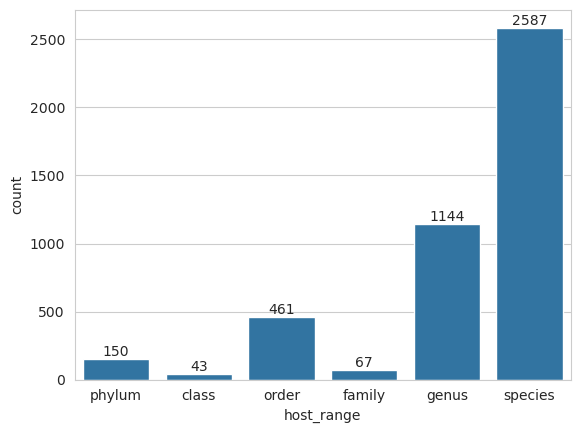

In [58]:
phylo_order = {
    "phylum": 0,
    "class": 1,
    "order": 2,
    "family": 3,
    "genus": 4,
    "species": 5,
    "narrow": 6,
}
aaa = (
    host_range_df.filter(pl.col("n_species_hosts") > 1)
    .group_by("host_range")
    .count()
    .with_columns(
        pl.col("host_range")
        .map_elements(lambda x: phylo_order.get(x, 99))
        .alias("phylo_sort")
    )
    .sort("phylo_sort")
    .drop("phylo_sort")
)
ax = sns.barplot(data=aaa, x="host_range", y="count")
for patch in ax.patches:
    height = patch.get_height()
    x = patch.get_x() + patch.get_width() / 2
    # Add a small offset so the text is not right at the top of the bar
    ax.text(x, height + 0.1, int(height), ha="center", va="bottom")

plt.savefig("../figures/host_range.pdf", bbox_inches="tight")

In [48]:
aaa

host_range,count
str,u32
"""phylum""",150
"""class""",43
"""order""",461
"""family""",67
"""genus""",1144
"""species""",2587


In [21]:
df_split_host.group_by("field_3").count().sort(by="count", descending=True).head(
    12
).get_column("field_3").to_list()

['o__Terriglobales',
 'o__Rhizobiales',
 'o__Burkholderiales',
 'o__Sphingomonadales',
 'o__Pseudomonadales',
 'o__Streptosporangiales',
 'o__Streptomycetales',
 'o__Mycobacteriales',
 'o__Enterobacterales',
 'o__Acidoferrales',
 'o__Actinomycetales',
 'o__Steroidobacterales']

In [22]:
df_split_host.group_by("field_3").agg(pl.col("ptu").unique()).explode("ptu").filter(
    pl.col("field_3").is_in(
        df_split_host.group_by("field_3")
        .count()
        .sort(by="count", descending=True)
        .head(12)
        .get_column("field_3")
        .to_list()
    )
)

field_3,ptu
str,str
"""o__Terriglobal…","""pOTU-05266"""
"""o__Terriglobal…","""pOTU-17516"""
"""o__Terriglobal…","""pOTU-11853"""
"""o__Terriglobal…","""pOTU-42494"""
"""o__Terriglobal…","""pOTU-01520"""
"""o__Terriglobal…","""pOTU-32695"""
"""o__Terriglobal…","""pOTU-54216"""
"""o__Terriglobal…","""pOTU-14857"""
"""o__Terriglobal…","""pOTU-04273"""


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Chord   [source,target]   (value)
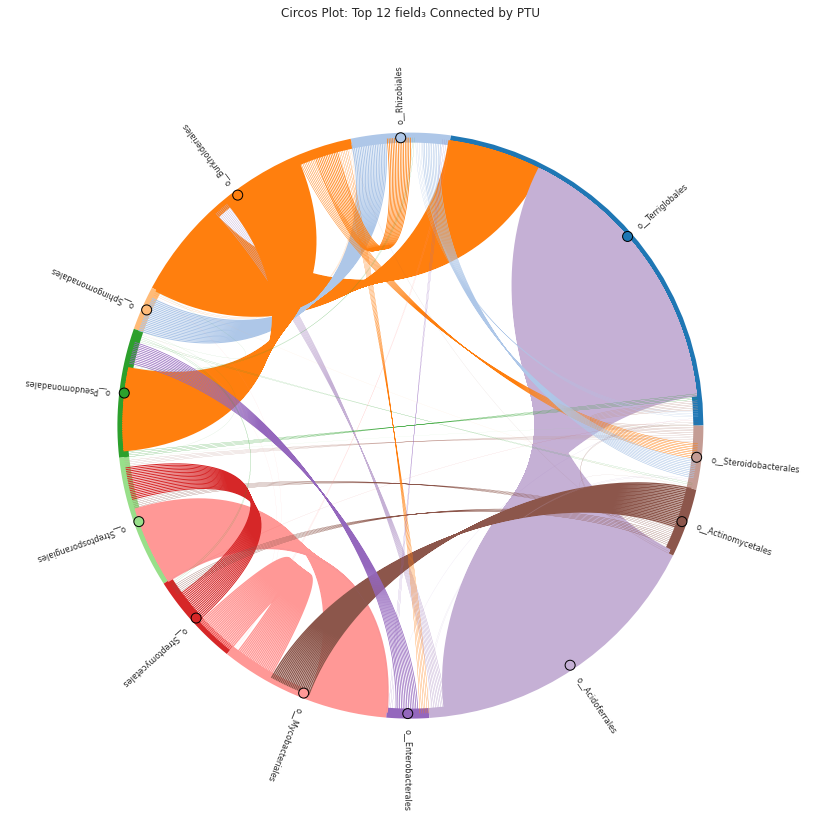

In [44]:
import pandas as pd
from itertools import combinations
from collections import Counter
import holoviews as hv
from holoviews import opts  # {{ edit_1 }}: Ensure opts is imported

hv.extension("matplotlib")

# Convert df_split_host (a polars DataFrame) to pandas.
df_split_host_pd = df_split_host.to_pandas()

# Compute the top x orders (field_3)
top12_orders = (
    df_split_host_pd.groupby("field_3")["ptu"]
    .count()
    .reset_index()
    .sort_values("ptu", ascending=False)
    .head(12)["field_3"]
    .tolist()
)

# Group by ptu and collect unique field_3 values per ptu.
ptu_field3 = (
    df_split_host_pd.groupby("ptu")["field_3"]
    .apply(lambda x: list(set(x)))
    .reset_index()
)

# Build edges by forming all unique pairs of field_3 per ptu, only using top12_orders.
edges_counter = Counter()
for _, row in ptu_field3.iterrows():
    # {{ edit_2 }}: Filter out None values and only include field_3 values within top12_orders.
    cats = [cat for cat in row["field_3"] if cat is not None and cat in top12_orders]
    if len(cats) > 1:
        # sort to have a canonical order for the pair
        for pair in combinations(sorted(cats), 2):
            edges_counter[pair] += 1

# Create a DataFrame of edges with columns [source, target, value]
edges_df = pd.DataFrame(
    [(s, t, w) for (s, t), w in edges_counter.items()],
    columns=["source", "target", "value"],
)

# Filter edges_df explicitly (redundant if filtering in loop) to enforce top12 orders.
edges_df = edges_df[
    edges_df["source"].isin(top12_orders) & edges_df["target"].isin(top12_orders)
]

# Define the nodes: all top 12 orders.
nodes = pd.DataFrame({"name": top12_orders})

# Create the chord diagram.
chord = hv.Chord((edges_df, hv.Dataset(nodes, "name")))

# Customize the chord diagram.
chord = chord.opts(
    opts.Chord(
        cmap="Category20",
        edge_color="source",
        node_color="name",
        labels="name",
        edge_linewidth=hv.dim("value") * 0.05,
        fig_size=400,
        title="Circos Plot: Top 12 field₃ Connected by PTU",
    )
)

# Save the chord diagram as a PDF file.
hv.save(chord, "../figures/chord_diagram_order.pdf", fmt="pdf")

# Display the chord diagram
chord

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Chord   [source,target]   (value)
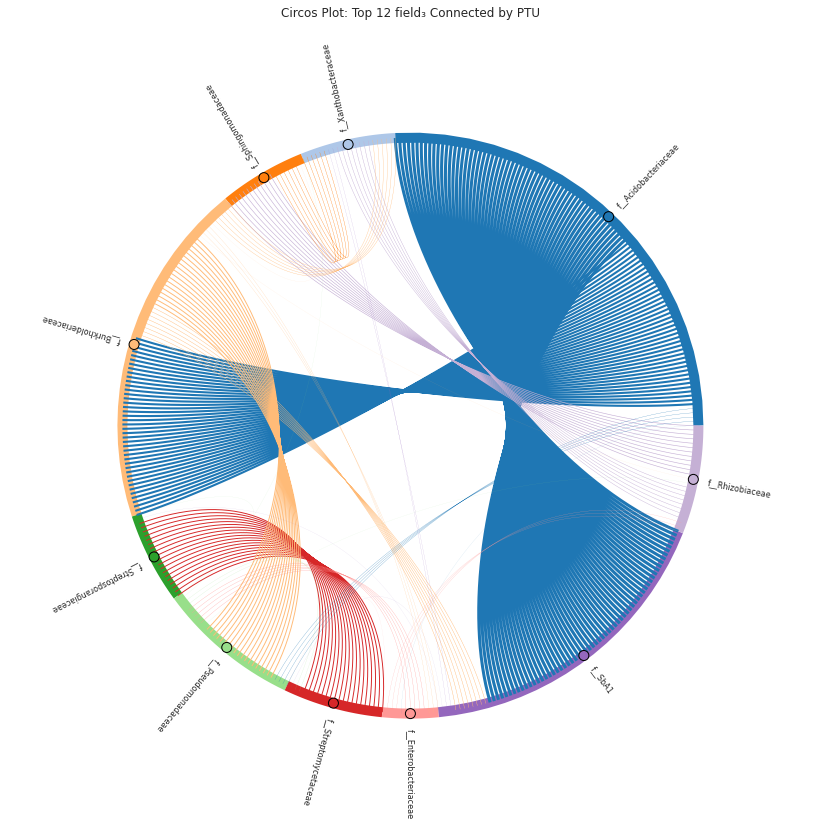

In [43]:
import pandas as pd
from itertools import combinations
from collections import Counter
import holoviews as hv
from holoviews import opts  # {{ edit_1 }}: Ensure opts is imported

hv.extension("matplotlib")

# Convert df_split_host (a polars DataFrame) to pandas.
df_split_host_pd = df_split_host.to_pandas()

# Compute the top x orders (field_3)
top12_orders = (
    df_split_host_pd.groupby("field_4")["ptu"]
    .count()
    .reset_index()
    .sort_values("ptu", ascending=False)
    .head(10)["field_4"]
    .tolist()
)

# Group by ptu and collect unique field_4 values per ptu.
ptu_field3 = (
    df_split_host_pd.groupby("ptu")["field_4"]
    .apply(lambda x: list(set(x)))
    .reset_index()
)

# Build edges by forming all unique pairs of field_4 per ptu, only using top12_orders.
edges_counter = Counter()
for _, row in ptu_field3.iterrows():
    # {{ edit_2 }}: Filter out None values and only include field_4 values within top12_orders.
    cats = [cat for cat in row["field_4"] if cat is not None and cat in top12_orders]
    if len(cats) > 1:
        # sort to have a canonical order for the pair
        for pair in combinations(sorted(cats), 2):
            edges_counter[pair] += 1

# Create a DataFrame of edges with columns [source, target, value]
edges_df = pd.DataFrame(
    [(s, t, w) for (s, t), w in edges_counter.items()],
    columns=["source", "target", "value"],
)

# Filter edges_df explicitly (redundant if filtering in loop) to enforce top12 orders.
edges_df = edges_df[
    edges_df["source"].isin(top12_orders) & edges_df["target"].isin(top12_orders)
]

# Define the nodes: all top 12 orders.
nodes = pd.DataFrame({"name": top12_orders})

# Create the chord diagram.
chord = hv.Chord((edges_df, hv.Dataset(nodes, "name")))

# Customize the chord diagram.
chord = chord.opts(
    opts.Chord(
        cmap="Category20",
        edge_color="source",
        node_color="name",
        labels="name",
        edge_linewidth=hv.dim("value") * 0.05,
        fig_size=400,
        title="Circos Plot: Top 12 field₃ Connected by PTU",
    )
)

# Save the chord diagram as a PDF file.
hv.save(chord, "../figures/chord_diagram_family.pdf", fmt="pdf")

# Display the chord diagram
chord

In [82]:
edges_df

,source,target,value
0,o__Burkholderiales,o__Terriglobales,60
1,o__Mycobacteriales,o__Streptosporangiales,49
2,o__Acidoferrales,o__Terriglobales,175
3,o__Acidoferrales,o__Burkholderiales,9
4,o__Actinomycetales,o__Mycobacteriales,26
5,o__Mycobacteriales,o__Streptomycetales,26
6,o__Actinomycetales,o__Streptosporangiales,5
7,o__Streptomycetales,o__Streptosporangiales,20
8,o__Rhizobiales,o__Sphingomonadales,21
9,o__Pseudomonadales,o__Terriglobales,4


In [17]:
df_split_host_agg = df_split_host.group_by("ptu").agg(
    pl.col("Plasmid").n_unique().alias("n_plasmids"),
    pl.col("field_1").n_unique().alias("n_phyla_hosts"),
    pl.col("field_1").unique().alias("phyla_hosts"),
    pl.col("field_2").n_unique().alias("n_class_hosts"),
    pl.col("field_3").n_unique().alias("n_order_hosts"),
    pl.col("field_4").n_unique().alias("n_family_hosts"),
    pl.col("field_5").n_unique().alias("n_genus_hosts"),
    pl.col("field_6").n_unique().alias("n_species_hosts"),
    pl.col("Ecosystem Subtype").n_unique().alias("n_ecosystems"),
    pl.col("Ecosystem Subtype").unique().alias("ecosystems"),
    pl.col("Ecosystem Subtype Custom").n_unique().alias("n_ecosystems_custom"),
    pl.col("Ecosystem Subtype Custom").unique().alias("ecosystems_custom"),
    pl.col("bdod (cg/cm³)").mean().alias("bdod"),
    pl.col("cec (mmol(c)/kg)").mean().alias("cec"),
    pl.col("cfvo (cm³/dm³)").mean().alias("cfvo"),
    pl.col("clay (g/kg)").mean().alias("clay"),
    pl.col("nitrogen (cg/kg)").mean().alias("nitrogen"),
    pl.col("ocd (dg/dm³)").mean().alias("ocd"),
    pl.col("phh2o (pH*10)").mean().alias("phh2o"),
    pl.col("sand (g/kg)").mean().alias("sand"),
    pl.col("silt (g/kg)").mean().alias("silt"),
    pl.col("soc (dg/kg)").mean().alias("soc"),
)

In [ ]:
df_split_host_agg.sort(
    ["n_species_hosts", "n_genus_hosts", "n_family_hosts", "n_plasmids"],
    descending=True,
).head(20)

ptu,n_plasmids,n_phyla_hosts,phyla_hosts,n_class_hosts,n_order_hosts,n_family_hosts,n_genus_hosts,n_species_hosts,n_ecosystems,ecosystems,n_ecosystems_custom,ecosystems_custom,bdod,cec,cfvo,clay,nitrogen,ocd,phh2o,sand,silt,soc
str,u32,u32,list[str],u32,u32,u32,u32,u32,u32,list[str],u32,list[str],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""pOTU-00007""",82,1,"[""p__Pseudomonadota""]",1,1,1,2,37,10,"[""Peat"", ""Agricultural land"", … ""Rhizosphere""]",7,"[""Other"", ""Rhizosphere"", … ""Grasslands""]",113.670886,327.898734,79.683544,205.088608,911.278481,499.658228,55.721519,427.037975,368.151899,1135.721519
"""pOTU-00046""",37,1,"[""p__Pseudomonadota""]",1,1,1,2,29,5,"[""Grasslands"", ""Unclassified"", … ""Agricultural land""]",5,"[""Unclassified"", ""Temperate forest"", … ""Agricultural land""]",128.378378,176.675676,27.972973,113.054054,1017.945946,274.675676,55.162162,701.0,186.189189,367.864865
"""pOTU-00021""",29,1,"[""p__Pseudomonadota""]",1,1,1,1,25,2,"[""Temperate forest"", ""Rhizosphere""]",2,"[""Rhizosphere"", ""Temperate forest""]",128.793103,279.241379,16.344828,320.931034,486.724138,391.448276,60.689655,224.689655,454.896552,592.793103
"""pOTU-00019""",37,1,"[""p__Actinomycetota""]",1,1,1,1,23,3,"[""Rhizosphere"", ""Unclassified"", ""Agricultural land""]",3,"[""Unclassified"", ""Rhizosphere"", ""Agricultural land""]",129.833333,247.5,77.666667,239.5,473.5,403.0,68.333333,339.833333,421.333333,376.833333
"""pOTU-00038""",31,1,"[""p__Actinomycetota""]",1,1,1,1,23,5,"[""Temperate forest"", ""Grasslands"", … ""Unclassified""]",5,"[""Temperate forest"", ""Unclassified"", … ""Rhizosphere""]",131.214286,221.857143,81.142857,192.357143,532.714286,336.642857,60.928571,458.142857,350.0,437.571429
"""pOTU-00060""",33,1,"[""p__Pseudomonadota""]",1,1,1,2,22,6,"[""Tundra"", ""Rhizosphere"", … ""Watershed""]",5,"[""Temperate forest"", ""Unclassified"", … ""Agricultural land""]",110.166667,358.733333,78.033333,172.666667,1011.333333,529.2,54.333333,455.966667,371.666667,1204.866667
"""pOTU-00037""",30,1,"[""p__Pseudomonadota""]",1,1,1,2,22,6,"[""Watershed"", ""Agricultural land"", … ""Rhizosphere""]",6,"[""Unclassified"", ""Rhizosphere"", … ""Other""]",115.2,273.2,109.466667,220.466667,642.666667,457.7,59.166667,415.7,363.7,894.533333
"""pOTU-00000""",145,1,"[""p__Acidobacteriota""]",1,1,2,6,21,8,"[""Watershed"", ""Peat"", … ""Temperate forest""]",7,"[""Grasslands"", ""Temperate forest"", … ""Rhizosphere""]",85.788732,434.542254,102.443662,121.394366,1012.711268,530.598592,53.302817,540.274648,338.387324,1771.140845
"""pOTU-00025""",43,1,"[""p__Pseudomonadota""]",1,1,1,3,21,2,"[""Rhizosphere"", ""Temperate forest""]",2,"[""Rhizosphere"", ""Temperate forest""]",115.461538,282.461538,81.333333,292.307692,976.307692,535.076923,54.615385,254.641026,453.230769,801.538462


In [28]:
ptus.head()

,Representative,Members,Length,oids,Ecosystem Subtype Custom,Ecosystem Subtype,WWF_MHTNAM,Origin,Full_origin
pOTU,,,,,,,,,
pOTU-00000,3300056587|Ga0562382_00532,"3300056587|Ga0562382_00532,3300041809|Ga045567...",187,"3300056587,3300041809,3300056587,3300055278,33...",Peat;Grasslands;Peat;Temperate forest;Peat;Pea...,Peat;Grasslands;Peat;Temperate forest;Peat;Pea...,Tundra;Temperate Conifer Forests;Tundra;Temper...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...
pOTU-00001,3300056791|Ga0562384_00281,"3300056791|Ga0562384_00281,3300054973|Ga049542...",158,"3300056791,3300054973,3300047661,3300051166,33...",Peat;Peat;Peat;Peat;Peat;Peat;Peat;Peat;Peat;P...,Peat;Peat;Peat;Peat;Peat;Peat;Peat;Peat;Peat;P...,Tundra;Tundra;Tundra;Tundra;Tundra;Tundra;Tund...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...
pOTU-00002,3300046709|Ga0495471_0000157,"3300046709|Ga0495471_0000157,3300046788|Ga0495...",105,"3300046709,3300046788,3300046461,3300046811,33...",Agricultural land;Agricultural land;Rhizospher...,Agricultural land;Agricultural land;Rhizospher...,Temperate Conifer Forests;Temperate Conifer Fo...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...
pOTU-00003,3300046559|Ga0495667_0000358,"3300046559|Ga0495667_0000358,3300036401|Ga0373...",98,"3300046559,3300036401,3300046543,3300046724,33...",Rhizosphere;Rhizosphere;Rhizosphere;Agricultur...,Rhizosphere;Rhizosphere;Rhizosphere;Agricultur...,Temperate Conifer Forests;Temperate Conifer Fo...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...
pOTU-00004,3300056834|Ga0562381_00901,"3300056834|Ga0562381_00901,3300056587|Ga056238...",85,"3300056834,3300056587,3300048796,3300048785,33...",Peat;Peat;Peat;Peat;Peat;Temperate forest;Gras...,Peat;Peat;Peat;Peat;Peat;Temperate forest;Gras...,Tundra;Tundra;Tundra;Tundra;Tundra;Temperate C...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...


In [80]:
# Check the potu origin for each order
(
    df.join(
        pl.from_pandas(ptus.reset_index()).select(pl.col("pOTU"), pl.col("Origin")),
        left_on="ptu",
        right_on="pOTU",
    )
    .rename({"Origin_right": "ptu_origin"})
    .group_by(["order", "ptu_origin"])
    .agg(pl.count("ptu_origin").alias("count"))
    .pivot(values="count", index="order", columns="ptu_origin")
    .fill_null(0)
    .filter(
        ((pl.col("Both") == 0) & (pl.col("Isolate") == 0) & (pl.col("Meta") > 0))
        & ((pl.col("order").is_not_null()) & (pl.col("order") != "o__"))
    )
    .sort(by="Meta", descending=True)
)


order,Both,Meta,Isolate
str,u32,u32,u32
"""o__Acidoferral…",0,1109,0
"""o__Steroidobac…",0,984,0
"""o__Solirubroba…",0,976,0
"""o__Acidimicrob…",0,768,0
"""o__Bryobactera…",0,599,0
"""o__AC-67""",0,343,0
"""o__Pyrinomonad…",0,225,0
"""o__ATCC43930""",0,217,0
"""o__Micropepsal…",0,191,0


In [78]:
(
    df.group_by(["order", "Ecosystem Subtype Custom"])
    .agg(pl.col("ptu").n_unique().alias("count"))
    .pivot(values="count", index="order", columns="Ecosystem Subtype Custom")
    .fill_null(0)
    .filter(
        (
            pl.fold(
                acc=pl.lit(0),
                function=lambda acc, x: acc + x,
                exprs=pl.exclude("order"),
            )
            == pl.max_horizontal(pl.exclude("order"))
        )
        & (pl.max_horizontal(pl.exclude("order")) > 0)
    )
    .with_columns(count=pl.sum_horizontal(pl.exclude("order")))
    .sort(by="count", descending=True)
)

order,Rhizosphere,Peat,Agricultural land,Grasslands,Tropical forest,Other,Unclassified,Temperate forest,count
str,u32,u32,u32,u32,u32,u32,u32,u32,u32
"""o__Thermacetog…",0,16,0,0,0,0,0,0,16
"""o__Vampirovibr…",10,0,0,0,0,0,0,0,10
"""o__UBA9655""",0,0,0,0,0,0,0,8,8
"""o__Borreliales…",0,0,0,0,0,0,7,0,7
"""o__Campylobact…",0,0,0,0,0,0,6,0,6
"""o__PGYV01""",0,5,0,0,0,0,0,0,5
"""o__Balneolales…",0,0,4,0,0,0,0,0,4
"""o__XYA12-FULL-…",4,0,0,0,0,0,0,0,4
"""o__Holophagale…",0,4,0,0,0,0,0,0,4


In [19]:
with open("../ptu_derep/complete_plasmids_derep.txt") as f:
    complete_plasmids = [x.strip() for x in f.readlines()]

df.group_by("Plasmid").agg(
    pl.col("phylum").n_unique().alias("n_phyla"), pl.col("phylum").unique()
).filter((pl.col("n_phyla") > 1) & (pl.col("Plasmid").is_in(complete_plasmids))).sort(
    "Plasmid"
)

Plasmid,n_phyla,phylum
str,u32,list[str]
"""3300005937|Ga0…",2,"[""p__Actinomycetota"", ""p__Pseudomonadota""]"
"""3300005985|Ga0…",2,"[""p__Pseudomonadota"", ""p__Acidobacteriota""]"
"""3300047641|Ga0…",2,"[""p__Acidobacteriota"", ""p__Pseudomonadota""]"
"""3300048773|Ga0…",2,"[""p__Acidobacteriota"", ""p__Verrucomicrobiota""]"
"""3300048775|Ga0…",2,"[""p__Acidobacteriota"", ""p__Pseudomonadota""]"
"""3300049719|Ga0…",2,"[""p__Pseudomonadota"", ""p__Acidobacteriota""]"
"""3300055372|Ga0…",2,"[""p__Pseudomonadota"", ""p__Acidobacteriota""]"
"""3300055372|Ga0…",2,"[""p__Acidobacteriota"", ""p__Pseudomonadota""]"
"""MGYA00645712|E…",2,"[""p__Actinomycetota"", ""p__Pseudomonadota""]"


In [ ]:
# # get ptus with more than 1 phylum
# with open("../ptus_more_than_1_phylum.txt", "w") as f:
#     for i in (
#         df_split_host_agg.filter(pl.col("n_phyla_hosts") > 1)
#         .get_column("ptu")
#         .to_list()
#     ):
#         f.write(i + "\n")

In [19]:
df_split_host_agg = df_split_host_agg.with_columns(
    host_range=pl.when(pl.col("n_genus_hosts") > 1)
    .then(pl.lit("broad"))
    .otherwise(pl.lit("narrow"))
)

df_split_host_agg.head()

ptu,n_plasmids,n_phyla_hosts,n_class_hosts,n_order_hosts,n_family_hosts,n_genus_hosts,n_species_hosts,n_ecosystems,ecosystems,n_ecosystems_custom,ecosystems_custom,bdod,cec,cfvo,clay,nitrogen,ocd,phh2o,sand,silt,soc,host_range
str,u32,u32,u32,u32,u32,u32,u32,u32,list[str],u32,list[str],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""PTU-01764""",5,1,1,1,1,2,4,2,"[""Rhizosphere"", ""Agricultural land""]",2,"[""Rhizosphere"", ""Agricultural land""]",124.2,248.2,94.4,261.4,905.0,473.2,57.6,336.0,402.8,628.0,"""broad"""
"""PTU-36088""",1,1,1,1,1,1,1,1,"[""Temperate forest""]",1,"[""Temperate forest""]",111.0,273.0,134.0,206.0,610.0,437.0,56.0,423.0,372.0,991.0,"""narrow"""
"""PTU-50931""",1,1,1,1,1,1,1,1,"[""Unclassified""]",1,"[""Unclassified""]",107.0,234.0,130.0,172.0,595.0,435.0,57.0,497.0,330.0,1082.0,"""narrow"""
"""PTU-38314""",1,1,1,1,1,1,1,1,"[""Peat""]",1,"[""Peat""]",62.0,475.0,112.0,110.0,973.0,517.0,54.0,562.0,328.0,2115.0,"""narrow"""
"""PTU-55573""",1,1,1,1,1,1,1,1,"[""Peat""]",1,"[""Peat""]",62.0,475.0,112.0,110.0,973.0,517.0,54.0,562.0,328.0,2115.0,"""narrow"""


In [20]:
df_split_host_agg.group_by("host_range").count()

host_range,count
str,u32
"""broad""",3499
"""narrow""",25986


In [21]:
host_range_soil_atts = df_split_host_agg.group_by("host_range").agg(
    [
        pl.col("bdod"),
        pl.col("cec"),
        pl.col("phh2o"),
        pl.col("nitrogen"),
        pl.col("clay"),
        pl.col("cfvo"),
        pl.col("ocd"),
        pl.col("sand"),
        pl.col("silt"),
        pl.col("soc"),
        pl.col("n_ecosystems"),
    ]
)

host_range_soil_atts

host_range,bdod,cec,phh2o,nitrogen,clay,cfvo,ocd,sand,silt,soc,n_ecosystems
str,list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[u32]
"""narrow""","[111.0, 107.0, … null]","[273.0, 234.0, … null]","[56.0, 57.0, … null]","[610.0, 595.0, … null]","[206.0, 172.0, … null]","[134.0, 130.0, … null]","[437.0, 435.0, … null]","[423.0, 497.0, … null]","[372.0, 330.0, … null]","[991.0, 1082.0, … null]","[1, 1, … 1]"
"""broad""","[124.2, 26.333333, … 133.0]","[248.2, 509.333333, … 198.0]","[57.6, 49.333333, … 68.0]","[905.0, 986.333333, … 188.0]","[261.4, 112.333333, … 358.0]","[94.4, 89.333333, … 96.0]","[473.2, 533.0, … 282.0]","[336.0, 357.333333, … 167.0]","[402.8, 530.666667, … 475.0]","[628.0, 2634.0, … 138.0]","[2, 1, … 1]"


In [22]:
df_for_box = host_range_soil_atts.to_pandas().set_index("host_range")
df_for_box = df_for_box.explode(
    [
        "bdod",
        "cec",
        "phh2o",
        "nitrogen",
        "clay",
        "cfvo",
        "ocd",
        "sand",
        "silt",
        "soc",
        "n_ecosystems",
    ]
)
df_for_box = df_for_box.reset_index()

In [23]:
a = pd.melt(df_for_box, id_vars="host_range")

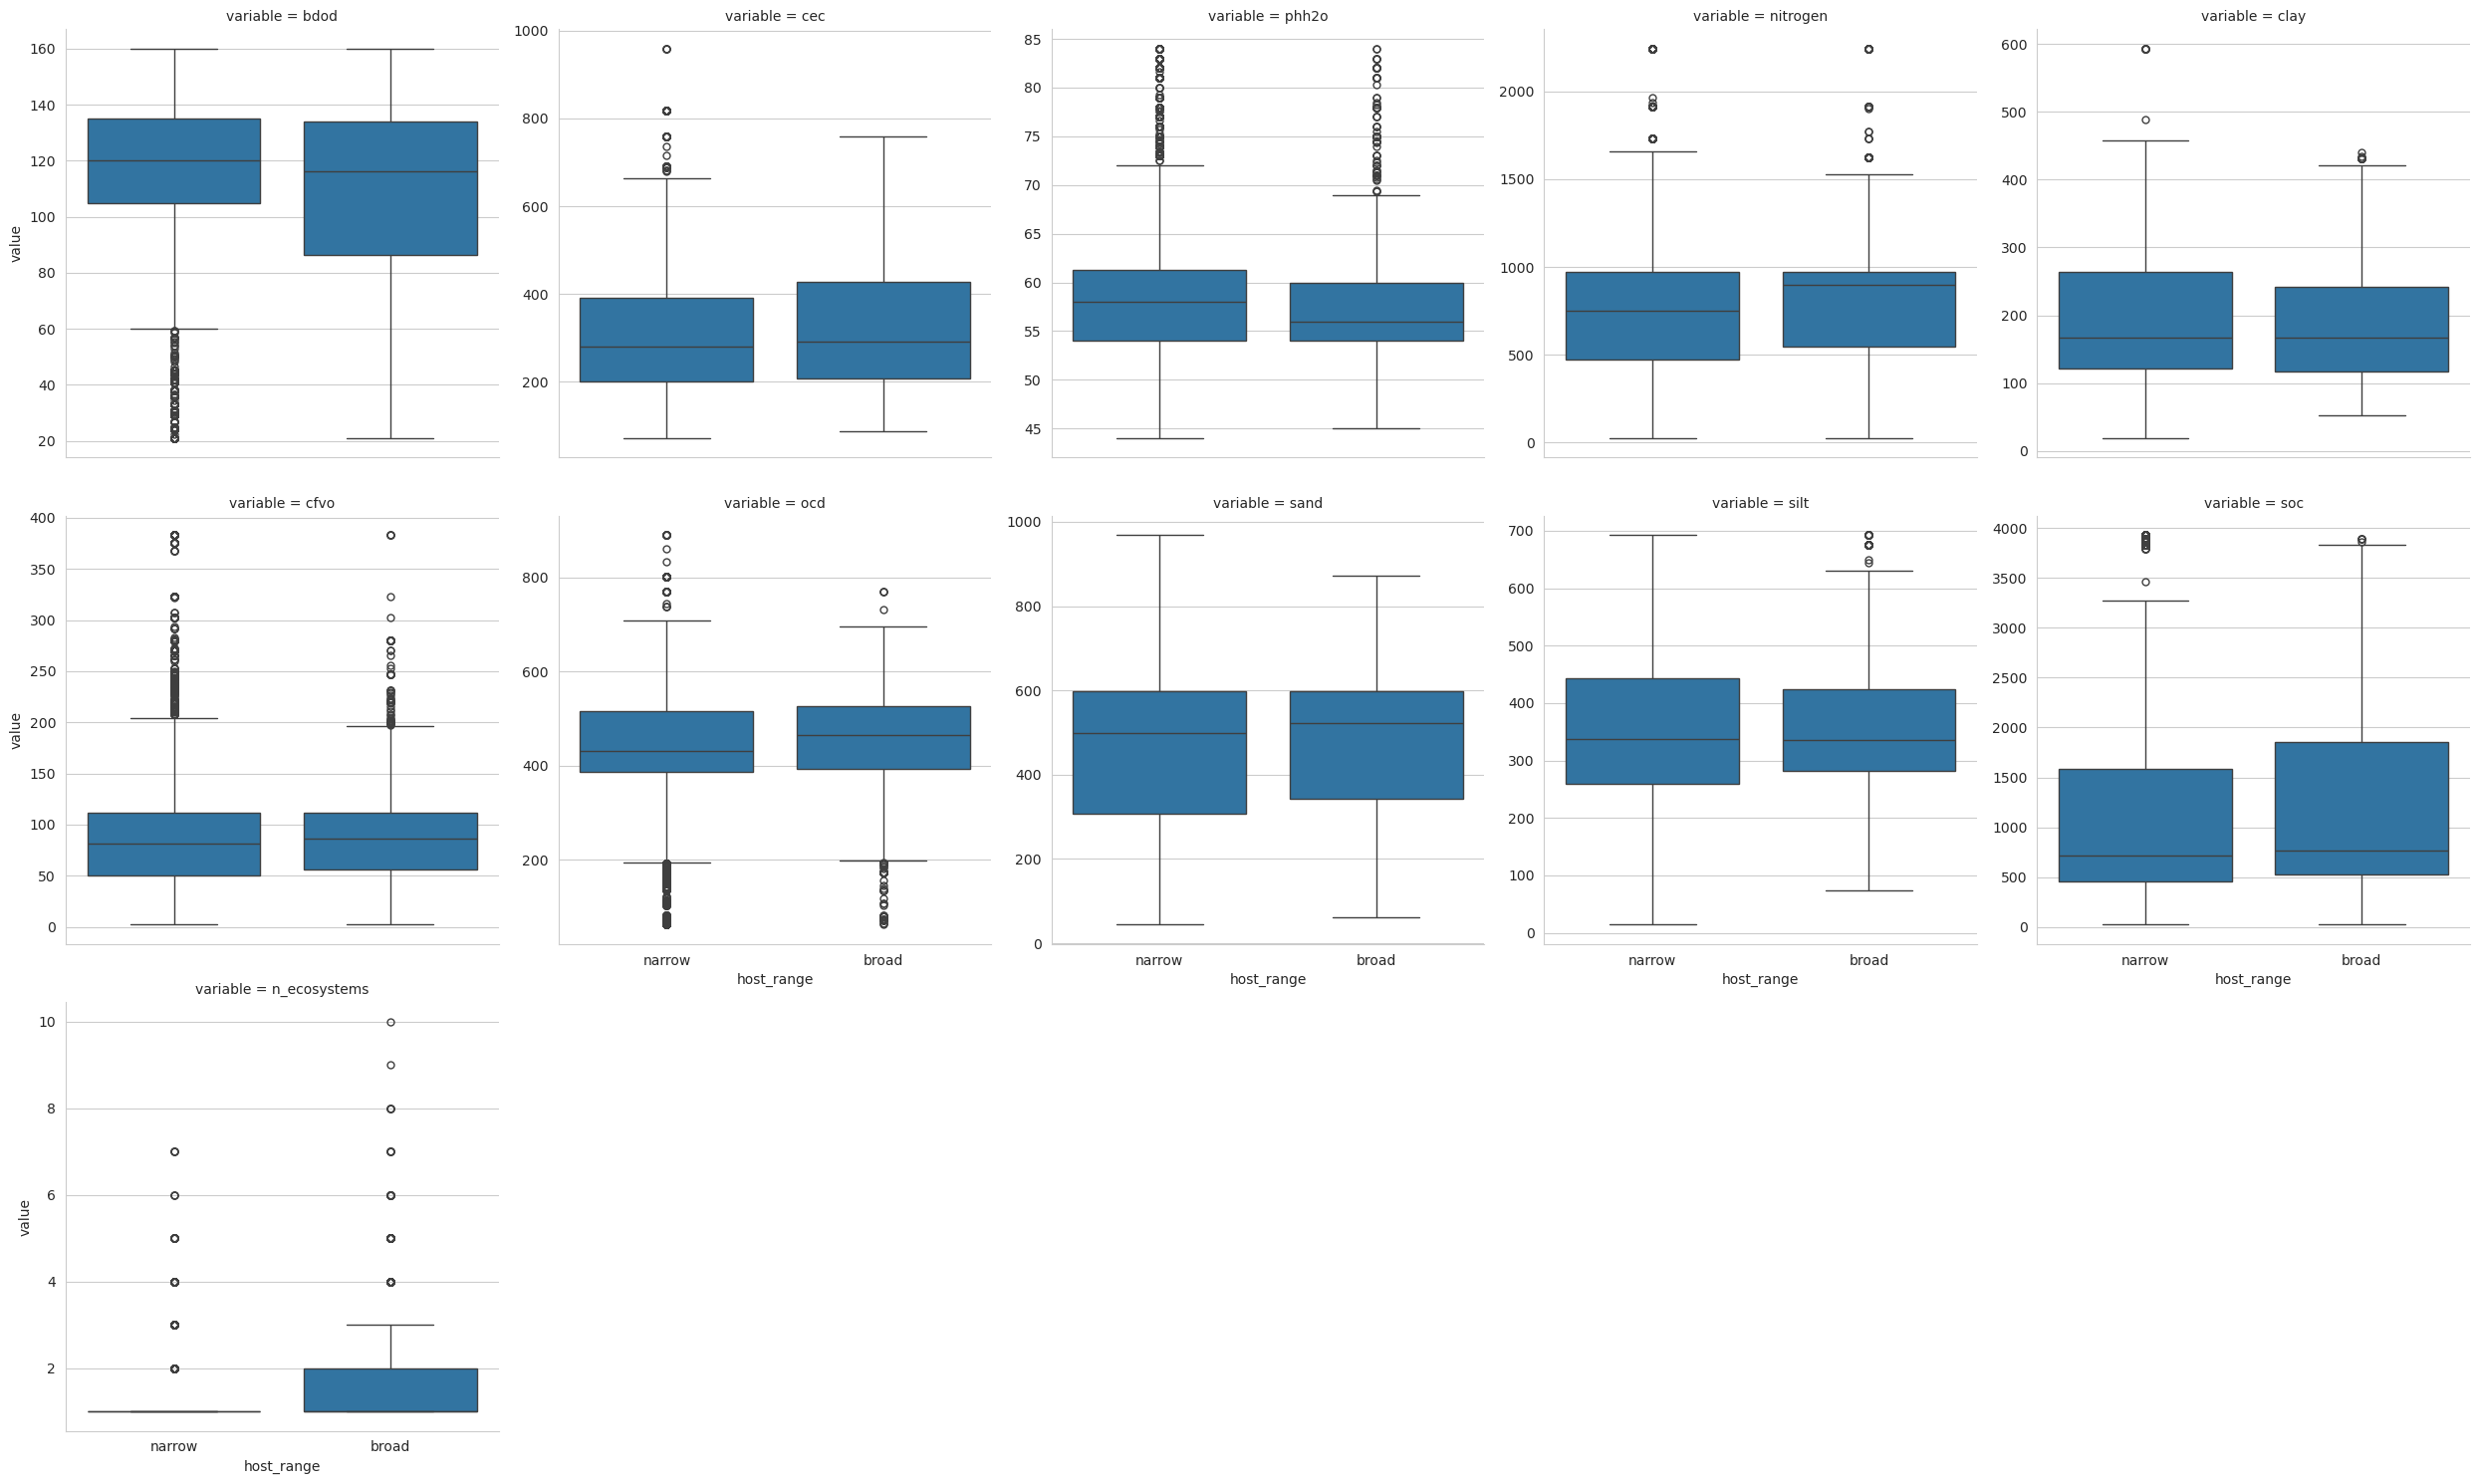

In [24]:
sns.catplot(
    data=a,
    x="host_range",
    y="value",
    kind="box",
    col="variable",
    col_wrap=5,
    sharey=False,
)
plt.savefig("../figures/host_range_soil_atts.pdf", bbox_inches="tight")

In [25]:
soil_atts = {}
for i in [
    "bdod",
    "cec",
    "phh2o",
    "nitrogen",
    "clay",
    "cfvo",
    "ocd",
    "sand",
    "silt",
    "soc",
]:
    soil_atts[i] = stats.mannwhitneyu(
        host_range_soil_atts[i][0],
        host_range_soil_atts[i][1],
        nan_policy="omit",
        alternative="greater",
    ).pvalue
for idx, i in enumerate(soil_atts.keys()):
    soil_atts[i] = stats.false_discovery_control(list(soil_atts.values()))[idx]

soil_atts_significant = {}
for k, v in soil_atts.items():
    if v < 0.05:
        soil_atts_significant[k] = v
        print(f"{k}: {v}")

bdod: 7.87965804934408e-05
phh2o: 5.506517313983806e-07
clay: 2.2398272612597564e-06
silt: 0.0012458677296395008


In [26]:
import numpy as np
from scipy import stats


def cliffs_delta(group1, group2):
    """
    Calculate Cliff's delta for two groups.

    :param group1: numpy array or list of values for group 1
    :param group2: numpy array or list of values for group 2
    :return: Cliff's delta
    """
    # Convert to numpy arrays if they aren't already
    group1 = np.asarray(group1)
    group2 = np.asarray(group2)

    # Calculate the Mann-Whitney U statistic
    statistic, _ = stats.mannwhitneyu(
        group1, group2, alternative="greater", nan_policy="omit"
    )

    # Calculate Cliff's delta
    n1, n2 = len(group1), len(group2)
    delta = (2 * statistic - n1 * n2) / (n1 * n2)

    return delta


for i in soil_atts_significant.keys():
    group1 = host_range_soil_atts[i][0]
    group2 = host_range_soil_atts[i][1]

    delta = cliffs_delta(group1, group2)
    print(f"Cliff's delta for {i}: {delta:.4f}")

Cliff's delta for bdod: -0.1751
Cliff's delta for phh2o: -0.1646
Cliff's delta for clay: -0.1666
Cliff's delta for silt: -0.1817


In [27]:
from collections import Counter

b = (
    df_split_host_agg.explode("ecosystems_custom")
    .unique(subset=["ptu", "ecosystems_custom"])
    .group_by("ecosystems_custom")
    .agg(pl.col("host_range"))
)

b = b.to_pandas().set_index("ecosystems_custom")

eco_host_range = {}

for i in b.index:
    eco_host_range[i] = Counter(b.loc[i]["host_range"])

eco_host_range

{'Temperate forest': Counter({'narrow': 4899, 'broad': 946}),
 'Grasslands': Counter({'narrow': 2017, 'broad': 399}),
 'Peat': Counter({'narrow': 3551, 'broad': 785}),
 'Rhizosphere': Counter({'narrow': 7286, 'broad': 1194}),
 'Agricultural land': Counter({'narrow': 2653, 'broad': 495}),
 'Tropical forest': Counter({'narrow': 442, 'broad': 137}),
 'Other': Counter({'narrow': 2186, 'broad': 483}),
 'Unclassified': Counter({'narrow': 4569, 'broad': 521})}

In [28]:
eco_host_range_df = pd.DataFrame(eco_host_range).T

eco_host_range_df["broad_ratio"] = eco_host_range_df["broad"] / (
    eco_host_range_df["broad"] + eco_host_range_df["narrow"]
)

eco_host_range_df = eco_host_range_df.reset_index()

eco_host_range_df

,index,broad,narrow,broad_ratio
0,Temperate forest,946,4899,0.161848
1,Grasslands,399,2017,0.165149
2,Peat,785,3551,0.181042
3,Rhizosphere,1194,7286,0.140802
4,Agricultural land,495,2653,0.157243
5,Tropical forest,137,442,0.236615
6,Other,483,2186,0.180967
7,Unclassified,521,4569,0.102358


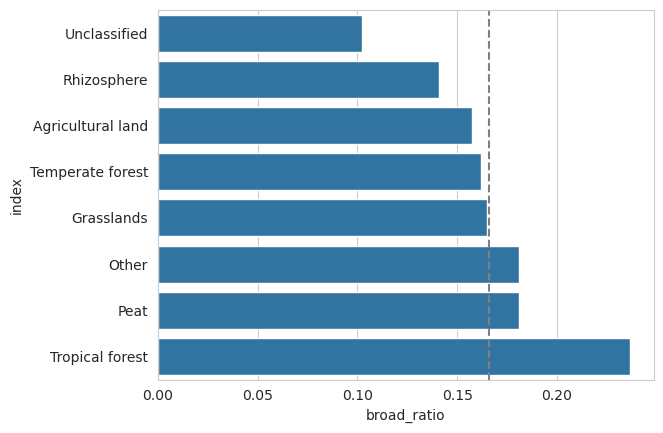

In [29]:
sns.barplot(
    data=eco_host_range_df.sort_values("broad_ratio"), x="broad_ratio", y="index"
)
plt.axvline(x=eco_host_range_df["broad_ratio"].mean(), color="grey", linestyle="dashed")
plt.savefig("../figures/eco_host_range.pdf", bbox_inches="tight")

In [67]:
test = (
    df_split_host_agg.sort(
        ["n_species_hosts", "n_genus_hosts", "n_family_hosts", "n_plasmids"],
        descending=True,
    )
    .explode("ecosystems_custom")
    .group_by("ecosystems_custom")
    .agg(pl.col("n_species_hosts"))
)

test

ecosystems_custom,n_species_hosts
str,list[u32]
"""Agricultural l…","[236, 207, … 1]"
"""Other""","[236, 130, … 1]"
"""Tropical fores…","[310, 145, … 1]"
"""Temperate fore…","[328, 252, … 1]"
"""Grasslands""","[310, 236, … 1]"
"""Unclassified""","[336, 242, … 1]"
"""Peat""","[252, 236, … 1]"
"""Rhizosphere""","[591, 378, … 1]"


<Axes: xlabel='n_species_hosts', ylabel='ecosystems_custom'>

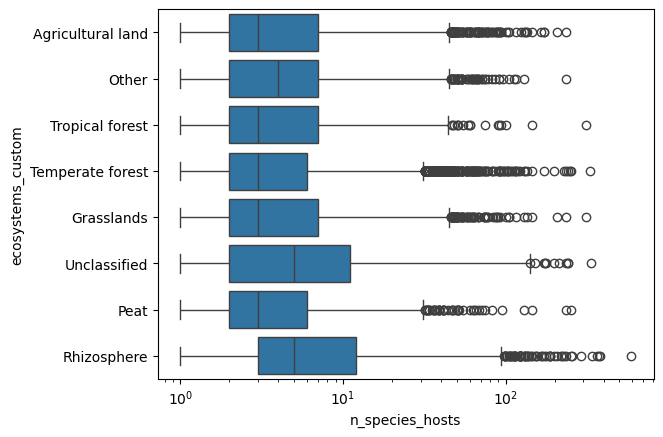

In [89]:
sns.boxplot(
    data=test.explode("n_species_hosts"),
    y="ecosystems_custom",
    x="n_species_hosts",
    log_scale=True,
)

In [69]:
stats.kruskal(*test["n_species_hosts"])

KruskalResult(statistic=1392.223594530442, pvalue=1.8585284302392977e-296)

In [92]:
dunn = posthoc_dunn(
    test.explode("n_species_hosts").to_pandas(),
    group_col="ecosystems_custom",
    val_col="n_species_hosts",
    p_adjust="holm",
)

dunn[dunn < 0.05]

,Agricultural land,Grasslands,Other,Peat,Rhizosphere,Temperate forest,Tropical forest,Unclassified
Agricultural land,NaN,NaN,NaN,7.517533e-04,1.011846e-79,2.990569e-03,NaN,1.864578e-41
Grasslands,NaN,NaN,NaN,1.461759e-02,1.771474e-70,4.745684e-02,NaN,1.117879e-37
Other,NaN,NaN,NaN,3.660354e-08,5.767343e-61,1.494079e-07,NaN,9.258561e-29
Peat,7.517533e-04,1.461759e-02,3.660354e-08,NaN,4.293397e-151,NaN,NaN,2.824567e-89
Rhizosphere,1.011846e-79,1.771474e-70,5.767343e-61,4.293397e-151,NaN,2.259950e-171,2.644504e-21,2.636035e-10
Temperate forest,2.990569e-03,4.745684e-02,1.494079e-07,NaN,2.259950e-171,NaN,NaN,4.049237e-99
Tropical forest,NaN,NaN,NaN,NaN,2.644504e-21,NaN,NaN,9.439472e-12
Unclassified,1.864578e-41,1.117879e-37,9.258561e-29,2.824567e-89,2.636035e-10,4.049237e-99,9.439472e-12,NaN


In [35]:
# df_split_host_agg.filter(pl.col('ptu').is_in(df_split_host_agg.sort(["n_species_hosts","n_genus_hosts", "n_family_hosts","n_plasmids"], descending=True).explode('ecosystems').filter(pl.col('ecosystems')=='Rhizosphere')['ptu'].to_list())).to_pandas()[['n_species_hosts', 'bdod', 'cec', 'cfvo', 'clay', 'nitrogen', 'ocd', 'phh2o', 'sand', 'silt', 'soc']].corr()

In [36]:
from scipy import stats

data = {
    "ptu": [
        "PTU-03991",
        "PTU-01174",
        "PTU-47430",
        "PTU-15251",
        "PTU-24309",
        "PTU-12345",
        "PTU-67890",
    ],
    "n_species_hosts": [591, 378, 376, 366, 340, 412, 299],
    "ecosystems": [
        ["Rhizosphere"],
        ["Rhizosphere"],
        ["Rhizosphere"],
        ["Rhizosphere"],
        ["Rhizosphere"],
        ["Peat"],
        ["Forest"],
    ],
}

df = pd.DataFrame(data)

# Simplify the ecosystems column
df["ecosystem"] = df["ecosystems"].apply(lambda x: x[0])
df_selected = df[["ptu", "ecosystem", "n_species_hosts"]]

# Group by ecosystem and calculate mean number of species-level hosts
ecosystem_grouped = (
    df_selected.groupby("ecosystem")["n_species_hosts"].mean().reset_index()
)
ecosystem_grouped.columns = ["Ecosystem", "Average Number of Species Hosts"]
print(ecosystem_grouped)

# Perform ANOVA test
ecosystem_data = [
    df_selected[df_selected["ecosystem"] == eco]["n_species_hosts"]
    for eco in df_selected["ecosystem"].unique()
]
anova_result = stats.f_oneway(*ecosystem_data)
print(
    f"ANOVA test result: F-value = {anova_result.statistic}, p-value = {anova_result.pvalue}"
)

     Ecosystem  Average Number of Species Hosts
0       Forest                            299.0
1         Peat                            412.0
2  Rhizosphere                            410.2
ANOVA test result: F-value = 0.5102791159549935, p-value = 0.6347693744165852


In [13]:
a = (
    df_split_host_agg.drop(
        [
            "ptu",
            "n_plasmids",
            "n_phyla_hosts",
            "n_class_hosts",
            "n_order_hosts",
            "n_family_hosts",
            "n_genus_hosts",
            "n_ecosystems",
            "ecosystems",
        ]
    )
    .to_pandas()
    .corr()
)
a.loc["n_species_hosts"]

n_species_hosts    1.000000
bdod               0.104439
cec               -0.094560
cfvo              -0.078100
clay               0.105829
nitrogen          -0.051273
ocd               -0.076131
phh2o              0.052950
sand              -0.067125
silt               0.024609
soc               -0.111963
Name: n_species_hosts, dtype: float64

In [14]:
# df_split_host_agg.with_columns(pl.col('ecosystems').map_elements(lambda x: str(x.to_list()))).write_csv('../tables_to_ask/split_host_atts.tsv', separator='\t')

/tmp/ipykernel_997894/1473521867.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_997894/1473521867.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_997894/1473521867.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_997894/1473521867.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_997894/1473521867.py:6: UserWarning: set_ticklabels()

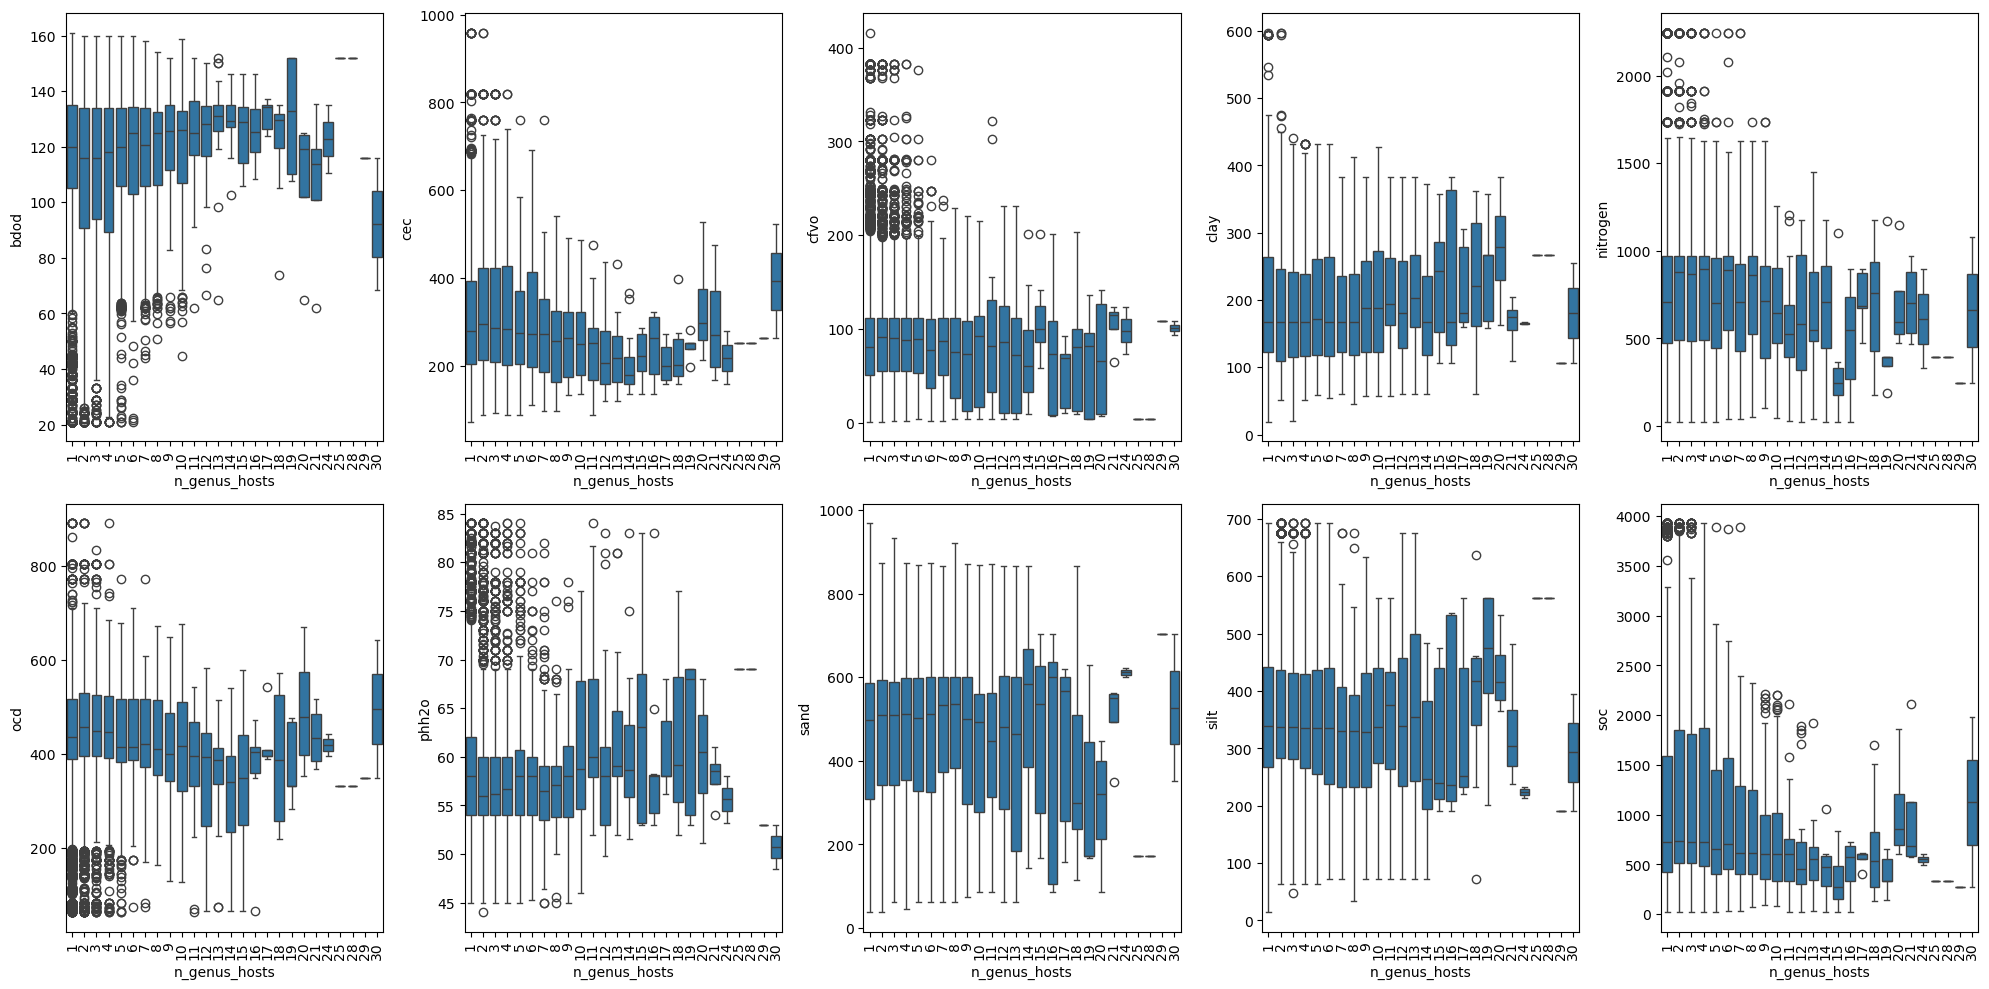

In [59]:
atts = [
    "bdod",
    "cec",
    "cfvo",
    "clay",
    "nitrogen",
    "ocd",
    "phh2o",
    "sand",
    "silt",
    "soc",
]
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20, 10))
axes = axes.flatten()
for i, att in enumerate(atts):
    sns.boxplot(
        data=df_split_host_agg.to_pandas(), x="n_genus_hosts", y=att, ax=axes[i]
    )
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)

fig.tight_layout()
# sns.boxplot(data=df_split_host_agg.to_pandas(), x="n_genus_hosts", y="bdod")

---

<Axes: xlabel='cec (mmol(c)/kg)', ylabel='field_4'>

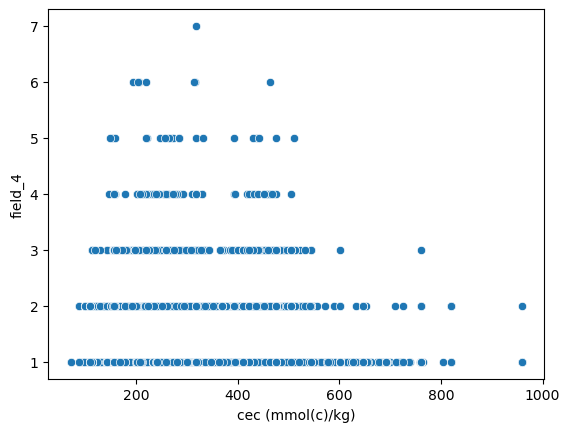

In [11]:
a = df_split_host.group_by("ptu").agg(
    pl.col("field_4").n_unique(),
    pl.col("bdod (cg/cm³)").mean(),
    pl.col("cec (mmol(c)/kg)").mean(),
)

sns.scatterplot(x=a["cec (mmol(c)/kg)"], y=a["field_4"])

In [11]:
df_split_host.group_by(["ptu"]).n_unique().drop(["Plasmid", "taxon_oid"]).select(
    pl.col("field_0")
).max()

field_0
u32
2


In [12]:
df_split_host.group_by(["ptu"]).n_unique().drop("Plasmid").filter(
    pl.col("field_0") == 2
)

ptu,field_0,field_1,field_2,field_3,field_4,field_5,field_6,taxon_oid,Ecosystem Subtype,Latitude,Longitude,Origin,Ecosystem Subtype Custom,soil_class
str,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
"""PTU-00261""",2,2,2,2,2,2,2,10,2,1,1,1,2,1
"""PTU-11989""",2,2,2,2,2,3,3,2,1,2,2,1,1,2
"""PTU-00118""",2,2,2,4,4,6,17,38,1,2,2,1,1,1


In [13]:
df_split_host.filter(pl.col("ptu") == "PTU-00118")[10]["Plasmid"][0]

'3300047640|Ga0497315_000154'

In [14]:
df_split_host.filter(pl.col("ptu") == "PTU-00261")

Plasmid,field_0,field_1,field_2,field_3,field_4,field_5,field_6,ptu,taxon_oid,Ecosystem Subtype,Latitude,Longitude,Origin,Ecosystem Subtype Custom,soil_class
str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,str,str
"""3300006049|Ga0…","""d__Bacteria""","""p__Tectomicrob…","""c__Entotheonel…","""o__Entotheonel…","""f__Entotheonel…","""g__SXND01""","""s__""","""PTU-00261""","""3300006049""","""Tree plantatio…",35.84,-83.96,"""Meta""","""Other""","""Luvisols"""
"""3300006969|Ga0…","""d__Bacteria""","""p__Tectomicrob…","""c__Entotheonel…","""o__Entotheonel…","""f__Entotheonel…","""g__SXND01""","""s__""","""PTU-00261""","""3300006969""","""Tree plantatio…",35.84,-83.96,"""Meta""","""Other""","""Luvisols"""
"""3300027909|Ga0…","""d__Bacteria""","""p__Tectomicrob…","""c__Entotheonel…","""o__Entotheonel…","""f__Entotheonel…","""g__SXND01""","""s__""","""PTU-00261""","""3300027909""","""Tree plantatio…",35.84,-83.96,"""Meta""","""Other""","""Luvisols"""
"""3300050498|nmd…","""d__Bacteria""","""p__Tectomicrob…","""c__Entotheonel…","""o__Entotheonel…","""f__Entotheonel…","""g__SXND01""","""s__""","""PTU-00261""","""3300050498""","""Tree plantatio…",35.84,-83.96,"""Meta""","""Other""","""Luvisols"""
"""3300050499|nmd…","""d__Bacteria""","""p__Tectomicrob…","""c__Entotheonel…","""o__Entotheonel…","""f__Entotheonel…","""g__SXND01""","""s__""","""PTU-00261""","""3300050499""","""Tree plantatio…",35.84,-83.96,"""Meta""","""Other""","""Luvisols"""
"""3300050501|nmd…","""d__Bacteria""","""p__Tectomicrob…","""c__Entotheonel…","""o__Entotheonel…","""f__Entotheonel…","""g__SXND01""","""s__""","""PTU-00261""","""3300050501""","""Tree plantatio…",35.84,-83.96,"""Meta""","""Other""","""Luvisols"""
"""3300050507|nmd…","""d__Archaea""","""p__Thermoprote…","""c__Nitrosospha…","""o__Nitrosospha…","""f__Nitrosospha…","""g__Nitrosospha…","""s__""","""PTU-00261""","""3300050507""","""Rhizosphere""",35.84,-83.96,"""Meta""","""Rhizosphere""","""Luvisols"""
"""3300050507|nmd…","""d__Archaea""","""p__Thermoprote…","""c__Nitrosospha…","""o__Nitrosospha…","""f__Nitrosospha…","""g__Nitrosospha…",null,"""PTU-00261""","""3300050507""","""Rhizosphere""",35.84,-83.96,"""Meta""","""Rhizosphere""","""Luvisols"""
"""3300050508|nmd…","""d__Bacteria""","""p__Tectomicrob…","""c__Entotheonel…","""o__Entotheonel…","""f__Entotheonel…","""g__SXND01""","""s__""","""PTU-00261""","""3300050508""","""Rhizosphere""",35.84,-83.96,"""Meta""","""Rhizosphere""","""Luvisols"""


In [15]:
df_split_host.filter(pl.col("ptu") == "PTU-11989")

Plasmid,field_0,field_1,field_2,field_3,field_4,field_5,field_6,ptu,taxon_oid,Ecosystem Subtype,Latitude,Longitude,Origin,Ecosystem Subtype Custom,soil_class
str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,str,str
"""3300036790|Ga0…","""d__Archaea""","""p__Halobacteri…","""c__Methanomicr…","""o__Methanomicr…","""f__Methanocull…","""g__Methanocull…",null,"""PTU-11989""","""3300036790""","""Temperate fore…",35.5,-121.0,"""Meta""","""Temperate fore…","""Kastanozems"""
"""3300037258|Ga0…","""d__Bacteria""","""p__Actinomycet…","""c__Actinomycet…","""o__Streptospor…","""f__Streptospor…","""g__Spirillospo…","""s__Spirillospo…","""PTU-11989""","""3300037258""","""Temperate fore…",37.0,-122.2,"""Meta""","""Temperate fore…","""Unknown"""
"""3300037258|Ga0…","""d__Bacteria""","""p__Actinomycet…","""c__Actinomycet…","""o__Streptospor…","""f__Streptospor…","""g__Palsa-506""","""s__Palsa-506 s…","""PTU-11989""","""3300037258""","""Temperate fore…",37.0,-122.2,"""Meta""","""Temperate fore…","""Unknown"""
"""3300037258|Ga0…","""d__Bacteria""","""p__Actinomycet…","""c__Actinomycet…","""o__Streptospor…","""f__Streptospor…","""g__Spirillospo…",null,"""PTU-11989""","""3300037258""","""Temperate fore…",37.0,-122.2,"""Meta""","""Temperate fore…","""Unknown"""


Any new hosts (order level) that are new? E.g, not in isolates

In [16]:
df_split_host.group_by(["field_3"]).agg("Origin").with_columns(
    pl.col("Origin").map_elements(lambda x: set(x))
).with_columns(
    pl.col("Origin").map_elements(len).alias("num_origin"),
    pl.col("Origin").map_elements(lambda x: ",".join(x)),
).filter((pl.col("num_origin") == 1) & (pl.col("Origin") == "Meta"))

field_3,Origin,num_origin
str,str,i64
"""o__UBA5704""","""Meta""",1
"""o__Nitrosococc…","""Meta""",1
"""o__DSM-16500""","""Meta""",1
"""o__Eubacterial…","""Meta""",1
"""o__UBA7540""","""Meta""",1
"""o__JAHEKZ01""","""Meta""",1
"""o__UBA2241""","""Meta""",1
"""o__B15-G4""","""Meta""",1
"""o__JACPHN01""","""Meta""",1


In [17]:
df_split_host.unique(subset=["ptu", "field_3"]).group_by(["field_3"]).count().sort(
    by="count", descending=True
)

field_3,count
str,u32
"""o__Rhizobiales…",6746
"""o__Terriglobal…",5239
"""o__Burkholderi…",4690
"""o__Sphingomona…",2823
"""o__Mycobacteri…",2533
"""o__Pseudomonad…",2269
"""o__Streptomyce…",2255
"""o__Streptospor…",2116
"""o__Enterobacte…",1501


Let's take a look at those weird plasmids with hosts in Archaea and Bacteria

In [18]:
df_split_host.group_by(["ptu"]).n_unique().filter(pl.col("field_0") > 1)

ptu,Plasmid,field_0,field_1,field_2,field_3,field_4,field_5,field_6,taxon_oid,Ecosystem Subtype,Latitude,Longitude,Origin,Ecosystem Subtype Custom,soil_class
str,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
"""PTU-00118""",56,2,2,2,4,4,6,17,38,1,2,2,1,1,1
"""PTU-00261""",10,2,2,2,2,2,2,2,10,2,1,1,1,2,1
"""PTU-11989""",2,2,2,2,2,2,3,3,2,1,2,2,1,1,2


It seems spureous, although some plasmids look like plasmids (https://img.jgi.doe.gov/cgi-bin/m/main.cgi?section=IMGScaffoldGraph&page=scaffoldGraph&taxon_oid=3300050391&data_type=assembled&scaffold_oid=Ga0506671_000452 and https://img.jgi.doe.gov/cgi-bin/m/main.cgi?section=IMGScaffoldGraph&page=scaffoldGraph&taxon_oid=3300046698&data_type=assembled&scaffold_oid=Ga0495367_009343). Have to ask Antonio

---

## Planctomycetota plasmids

In [ ]:
df_is_planctomycetota = df_split_host.with_columns(
    is_plancto=pl.col("field_1") == "p__Planctomycetota"
)
df_is_planctomycetota.head()

Plasmid,field_0,field_1,field_2,field_3,field_4,field_5,field_6,ptu,taxon_oid,Ecosystem Subtype,Latitude,Longitude,Origin,Ecosystem Subtype Custom,soil_class,bdod (cg/cm³),cec (mmol(c)/kg),cfvo (cm³/dm³),clay (g/kg),nitrogen (cg/kg),ocd (dg/dm³),phh2o (pH*10),sand (g/kg),silt (g/kg),soc (dg/kg),geometry,index_right,ECO_NAME,WWF_REALM,RealmMHT,WWF_REALM2,WWF_MHTNUM,WWF_MHTNAM,is_plancto
str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,f64,str,str,str,str,f64,str,bool
"""2088090014|GPI…","""d__Bacteria""","""p__Pseudomonad…","""c__Alphaproteo…","""o__Rhizobiales…","""f__Methylolige…","""g__Methylocean…","""s__Methylocean…","""PTU-03839""","""2088090014""","""Grasslands""",39.0,-77.1,"""Meta""","""Grasslands""","""Luvisols""",null,null,null,null,null,null,null,null,null,null,"""POINT (-77.1 3…",710.0,"""Lower New Engl…","""NA""","""NA4""","""Nearctic""",4.0,"""Temperate Broa…",false
"""2088090014|GPI…","""d__Bacteria""","""p__Pseudomonad…","""c__Alphaproteo…","""o__Rhizobiales…","""f__Methylolige…","""g__Methylocean…",null,"""PTU-03839""","""2088090014""","""Grasslands""",39.0,-77.1,"""Meta""","""Grasslands""","""Luvisols""",null,null,null,null,null,null,null,null,null,null,"""POINT (-77.1 3…",710.0,"""Lower New Engl…","""NA""","""NA4""","""Nearctic""",4.0,"""Temperate Broa…",false
"""2088090014|GPI…","""d__Bacteria""","""p__Acidobacter…","""c__Vicinamibac…","""o__Vicinamibac…","""f__UBA2999""","""g__2-02-FULL-6…","""s__2-02-FULL-6…","""PTU-57609""","""2088090014""","""Grasslands""",39.0,-77.1,"""Meta""","""Grasslands""","""Luvisols""",null,null,null,null,null,null,null,null,null,null,"""POINT (-77.1 3…",710.0,"""Lower New Engl…","""NA""","""NA4""","""Nearctic""",4.0,"""Temperate Broa…",false
"""2088090014|GPI…","""d__Bacteria""","""p__Acidobacter…","""c__Vicinamibac…","""o__Vicinamibac…","""f__UBA2999""","""g__2-02-FULL-6…",null,"""PTU-57609""","""2088090014""","""Grasslands""",39.0,-77.1,"""Meta""","""Grasslands""","""Luvisols""",null,null,null,null,null,null,null,null,null,null,"""POINT (-77.1 3…",710.0,"""Lower New Engl…","""NA""","""NA4""","""Nearctic""",4.0,"""Temperate Broa…",false
"""2088090015|GPI…","""d__Bacteria""","""p__Actinomycet…","""c__Thermoleoph…","""o__Gaiellales""","""f__Gaiellaceae…","""g__GMQP-bins7""",null,"""PTU-07712""","""2088090015""","""Grasslands""",39.0,-77.1,"""Meta""","""Grasslands""","""Luvisols""",null,null,null,null,null,null,null,null,null,null,"""POINT (-77.1 3…",710.0,"""Lower New Engl…","""NA""","""NA4""","""Nearctic""",4.0,"""Temperate Broa…",false


<Axes: xlabel='is_plancto', ylabel='nitrogen (cg/kg)'>

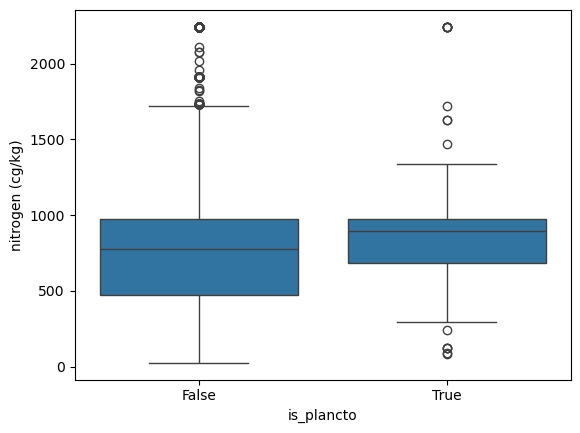

In [ ]:
# Are soils with more nitrogen the ones where planctomycetota are found?
a = df_is_planctomycetota.group_by("ptu").agg(
    pl.col("is_plancto").any(),
    pl.col("bdod (cg/cm³)").mean(),
    pl.col("cec (mmol(c)/kg)").mean(),
    pl.col("nitrogen (cg/kg)").mean(),
)
sns.boxplot(x=a["is_plancto"], y=a["nitrogen (cg/kg)"])

In [ ]:
from scipy.stats import kruskal

kruskal(
    df_is_planctomycetota.filter(pl.col("is_plancto"))["nitrogen (cg/kg)"]
    .fill_null(np.nan)
    .to_list(),
    df_is_planctomycetota.filter(~pl.col("is_plancto"))["nitrogen (cg/kg)"]
    .fill_null(np.nan)
    .to_list(),
    nan_policy="omit",
)

KruskalResult(statistic=26.944946134674655, pvalue=2.0933379431647245e-07)

In [19]:
df_split_host.filter(pl.col("field_1") == "p__Planctomycetota").unique(
    subset=["ptu", "Ecosystem Subtype Custom"]
).group_by("Ecosystem Subtype Custom").count()

Ecosystem Subtype Custom,count
str,u32
"""Temperate fore…",44
"""Other""",16
"""Unclassified""",24
"""Grasslands""",18
"""Tropical fores…",6
"""Peat""",53
"""Agricultural l…",16
"""Rhizosphere""",18


In [20]:
df_split_host.group_by("ptu").n_unique().filter(
    (pl.col("field_4") > 1) & (pl.col("field_3") == 1)
)["ptu"]

ptu
str
"""PTU-06550"""
"""PTU-03032"""
"""PTU-15079"""
"""PTU-41072"""
"""PTU-13362"""
"""PTU-47728"""
"""PTU-34884"""
"""PTU-02373"""
"""PTU-45203"""


In [21]:
with open("one_family_host.txt", "w") as f:
    for i in (
        df_split_host.group_by("ptu").n_unique().filter((pl.col("field_4") == 1))["ptu"]
    ):
        f.write(i + "\n")

Multiple host range, what are the main ecosystems?

In [22]:
multi_fam_ptus = (
    df_split_host.group_by("ptu")
    .n_unique()
    .filter((pl.col("field_4") > 1) & (pl.col("field_3") == 1))["ptu"]
    .to_list()
)

multi_fam_ptu_count_per_eco = (
    df_split_host.filter(pl.col("ptu").is_in(multi_fam_ptus))
    .unique(subset=["ptu", "Ecosystem Subtype Custom"])["Ecosystem Subtype Custom"]
    .value_counts()
    .sort(by="count", descending=True)
)

Ecosystem Subtype Custom,count
str,u32
"""Peat""",384
"""Rhizosphere""",249
"""Temperate fore…",246
"""Unclassified""",226
"""Agricultural l…",202
"""Other""",166
"""Grasslands""",145
"""Tropical fores…",26


Proportion of Broad Host Range PTUs= 
Number of Broad Host Range PTUs in Ecosystem/Total PTUs in Ecosystem
​

In [33]:
multi_fam_ptu_count_per_eco = multi_fam_ptu_count_per_eco.with_columns(
    total_ptus=pl.col("Ecosystem Subtype Custom").map_elements(
        lambda x: ptus_per_eco.get(x)
    )
).with_columns(
    [
        (pl.col("count") / pl.col("total_ptus")).alias("prop"),
        (pl.col("total_ptus") - pl.col("count")).alias("num_ptus_non_broad"),
    ]
)
multi_fam_ptu_count_per_eco

Ecosystem Subtype Custom,count,total_ptus,prop,num_ptus_non_broad
str,u32,i64,f64,i64
"""Peat""",384,7847,0.048936,7463
"""Rhizosphere""",249,14725,0.01691,14476
"""Temperate fore…",246,12841,0.019157,12595
"""Unclassified""",226,12591,0.017949,12365
"""Agricultural l…",202,7095,0.028471,6893
"""Other""",166,6195,0.026796,6029
"""Grasslands""",145,5374,0.026982,5229
"""Tropical fores…",26,1360,0.019118,1334


In [29]:
from scipy.stats import chi2_contingency

# Data: Counts of PTUs with broad host range and total PTUs for each ecosystem
# [Number of Broad Host Range PTUs, Total PTUs - Number of Broad Host Range PTUs]
data = [
    [384, 7847 - 384],  # Peat
    [249, 14725 - 249],  # Rhizosphere
    [246, 12841 - 246],  # Temperate Forest
    [226, 12591 - 226],  # Unclassified
    [202, 7095 - 202],  # Agricultural Land
    [166, 6195 - 166],  # Other
    [145, 5374 - 145],  # Grasslands
    [26, 1360 - 26],  # Tropical Forest
]

# Perform the chi-square test for independence
chi2, p_value, dof, expected = chi2_contingency(data)

print("Chi-square statistic:", chi2)
print("p-value:", p_value)

Chi-square statistic: 281.99287875842896
p-value: 4.2187356771784597e-57


In [75]:
all_ptus = pd.read_csv

Plasmid,host,ptu,taxon_oid,Ecosystem Subtype,Latitude,Longitude,Origin,Ecosystem Subtype Custom,soil_class
str,str,str,str,str,f64,f64,str,str,str
"""2088090014|GPI…","""d__Bacteria;p_…","""PTU-03382""","""2088090014""","""Grasslands""",39.0,-77.1,"""Meta""","""Grasslands""","""Luvisols"""
"""2088090014|GPI…","""d__Bacteria;p_…","""PTU-03382""","""2088090014""","""Grasslands""",39.0,-77.1,"""Meta""","""Grasslands""","""Luvisols"""
"""2088090014|GPI…","""d__Bacteria;p_…","""PTU-59132""","""2088090014""","""Grasslands""",39.0,-77.1,"""Meta""","""Grasslands""","""Luvisols"""
"""2088090014|GPI…","""d__Bacteria;p_…","""PTU-59132""","""2088090014""","""Grasslands""",39.0,-77.1,"""Meta""","""Grasslands""","""Luvisols"""
"""2088090015|GPI…","""d__Bacteria;p_…","""PTU-06235""","""2088090015""","""Grasslands""",39.0,-77.1,"""Meta""","""Grasslands""","""Luvisols"""


---
### PTU hosts: are they from the same sample? Infer HGT

In [17]:
df_split_host.head()

Plasmid,field_0,field_1,field_2,field_3,field_4,field_5,field_6,ptu,taxon_oid,Ecosystem Subtype,Latitude,Longitude,Origin,Ecosystem Subtype Custom,soil_class
str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,str,str
"""2088090014|GPI…","""d__Bacteria""","""p__Pseudomonad…","""c__Alphaproteo…","""o__Rhizobiales…","""f__Methylolige…","""g__Methylocean…","""s__Methylocean…","""PTU-03382""","""2088090014""","""Grasslands""",39.0,-77.1,"""Meta""","""Grasslands""","""Luvisols"""
"""2088090014|GPI…","""d__Bacteria""","""p__Pseudomonad…","""c__Alphaproteo…","""o__Rhizobiales…","""f__Methylolige…","""g__Methylocean…",null,"""PTU-03382""","""2088090014""","""Grasslands""",39.0,-77.1,"""Meta""","""Grasslands""","""Luvisols"""
"""2088090014|GPI…","""d__Bacteria""","""p__Acidobacter…","""c__Vicinamibac…","""o__Vicinamibac…","""f__UBA2999""","""g__2-02-FULL-6…","""s__2-02-FULL-6…","""PTU-59132""","""2088090014""","""Grasslands""",39.0,-77.1,"""Meta""","""Grasslands""","""Luvisols"""
"""2088090014|GPI…","""d__Bacteria""","""p__Acidobacter…","""c__Vicinamibac…","""o__Vicinamibac…","""f__UBA2999""","""g__2-02-FULL-6…",null,"""PTU-59132""","""2088090014""","""Grasslands""",39.0,-77.1,"""Meta""","""Grasslands""","""Luvisols"""
"""2088090015|GPI…","""d__Bacteria""","""p__Actinomycet…","""c__Thermoleoph…","""o__Gaiellales""","""f__Gaiellaceae…","""g__GMQP-bins7""",null,"""PTU-06235""","""2088090015""","""Grasslands""",39.0,-77.1,"""Meta""","""Grasslands""","""Luvisols"""


In [18]:
ptu_unique_host_df = (
    df_split_host.drop_nulls(subset=["Latitude", "Longitude"])
    .with_columns(lat_long=pl.concat_list(["Latitude", "Longitude"]))
    .group_by("ptu")
    .agg(
        [
            pl.col("field_1").flatten(),
            pl.col("field_2").flatten(),
            pl.col("field_3").flatten(),
            pl.col("field_4").flatten(),
            pl.col("lat_long").unique(),
            pl.col("Plasmid").unique().len().alias("num_plasmids_with_host"),
        ]
    )
    .with_columns(
        num_uniq_p=pl.col("field_1").map_elements(lambda x: len(set(x))),
        num_uniq_c=pl.col("field_2").map_elements(lambda x: len(set(x))),
        num_uniq_o=pl.col("field_3").map_elements(lambda x: len(set(x))),
        num_uniq_f=pl.col("field_4").map_elements(lambda x: len(set(x))),
    )
)

ptu_unique_host_df.head()

ptu,field_1,field_2,field_3,field_4,lat_long,num_plasmids_with_host,num_uniq_p,num_uniq_c,num_uniq_o,num_uniq_f
str,list[str],list[str],list[str],list[str],list[list[f64]],u32,i64,i64,i64,i64
"""PTU-47904""","[""p__Pseudomonadota"", ""p__Pseudomonadota"", … ""p__Pseudomonadota""]","[""c__Gammaproteobacteria"", ""c__Gammaproteobacteria"", … ""c__Gammaproteobacteria""]","[""o__Enterobacterales"", ""o__Enterobacterales"", … ""o__Enterobacterales""]","[""f__Enterobacteriaceae"", ""f__Enterobacteriaceae"", … ""f__Enterobacteriaceae""]","[[42.79, -84.39], [41.92, -93.75], [44.59, -123.19]]",4,1,1,1,1
"""PTU-50965""","[""p__Pseudomonadota"", ""p__Pseudomonadota""]","[""c__Gammaproteobacteria"", ""c__Gammaproteobacteria""]","[""o__Enterobacterales"", ""o__Enterobacterales""]","[""f__Enterobacteriaceae"", ""f__Enterobacteriaceae""]","[[41.89, -103.69]]",1,1,1,1,1
"""PTU-13138""","[""p__Pseudomonadota"", ""p__Pseudomonadota"", … ""p__Pseudomonadota""]","[""c__Gammaproteobacteria"", ""c__Gammaproteobacteria"", … ""c__Gammaproteobacteria""]","[""o__Enterobacterales"", ""o__Enterobacterales"", … ""o__Enterobacterales""]","[""f__Enterobacteriaceae"", ""f__Enterobacteriaceae"", … ""f__Enterobacteriaceae""]","[[60.2, 24.97], [43.07, -89.4], … [-26.69, 27.07]]",11,1,1,1,1
"""PTU-00214""","[""p__Bacillota"", ""p__Bacillota"", … ""p__Bacillota""]","[""c__Bacilli"", ""c__Bacilli"", … ""c__Bacilli""]","[""o__Bacillales"", ""o__Bacillales"", … ""o__Bacillales""]","[""f__Bacillaceae_G"", ""f__Bacillaceae_G"", … ""f__Bacillaceae_G""]","[[-34.61, -58.44], [35.88, -106.3], … [52.76, 23.87]]",8,1,1,1,2
"""PTU-21967""","[""p__Pseudomonadota"", ""p__Pseudomonadota"", … ""p__Pseudomonadota""]","[""c__Alphaproteobacteria"", ""c__Alphaproteobacteria"", … ""c__Alphaproteobacteria""]","[""o__Rhizobiales"", ""o__Rhizobiales"", … ""o__Rhizobiales""]","[""f__Devosiaceae"", ""f__Devosiaceae"", … ""f__Devosiaceae""]","[[40.02, -105.27]]",1,1,1,1,1


In [19]:
from geopy.distance import geodesic
from itertools import combinations


def mean_distance(coordinates):
    """
    Calculate the mean distance from a set of latitude and longitude coordinates
    """
    total_distance = 0
    num_pairs = 0
    if len(coordinates) == 1:
        mean_distance = 0
    else:
        for coord1, coord2 in combinations(coordinates, 2):
            distance = geodesic(coord1, coord2).meters
            total_distance += distance
            num_pairs += 1

        mean_distance = total_distance / num_pairs

    return float(mean_distance)


ptu_unique_host_df = ptu_unique_host_df.with_columns(
    mean_dist=pl.col("lat_long").map_elements(lambda x: mean_distance(x.to_list())),
    num_unique_coords=pl.col("lat_long").map_elements(len),
)

In [20]:
ptu_unique_host_df.head()

ptu,field_1,field_2,field_3,field_4,lat_long,num_plasmids_with_host,num_uniq_p,num_uniq_c,num_uniq_o,num_uniq_f,mean_dist,num_unique_coords
str,list[str],list[str],list[str],list[str],list[list[f64]],u32,i64,i64,i64,i64,f64,i64
"""PTU-47904""","[""p__Pseudomonadota"", ""p__Pseudomonadota"", … ""p__Pseudomonadota""]","[""c__Gammaproteobacteria"", ""c__Gammaproteobacteria"", … ""c__Gammaproteobacteria""]","[""o__Enterobacterales"", ""o__Enterobacterales"", … ""o__Enterobacterales""]","[""f__Enterobacteriaceae"", ""f__Enterobacteriaceae"", … ""f__Enterobacteriaceae""]","[[42.79, -84.39], [41.92, -93.75], [44.59, -123.19]]",4,1,1,1,1,2.0925e6,3
"""PTU-50965""","[""p__Pseudomonadota"", ""p__Pseudomonadota""]","[""c__Gammaproteobacteria"", ""c__Gammaproteobacteria""]","[""o__Enterobacterales"", ""o__Enterobacterales""]","[""f__Enterobacteriaceae"", ""f__Enterobacteriaceae""]","[[41.89, -103.69]]",1,1,1,1,1,0.0,1
"""PTU-13138""","[""p__Pseudomonadota"", ""p__Pseudomonadota"", … ""p__Pseudomonadota""]","[""c__Gammaproteobacteria"", ""c__Gammaproteobacteria"", … ""c__Gammaproteobacteria""]","[""o__Enterobacterales"", ""o__Enterobacterales"", … ""o__Enterobacterales""]","[""f__Enterobacteriaceae"", ""f__Enterobacteriaceae"", … ""f__Enterobacteriaceae""]","[[60.2, 24.97], [43.07, -89.4], … [-26.69, 27.07]]",11,1,1,1,1,9.7162e6,7
"""PTU-00214""","[""p__Bacillota"", ""p__Bacillota"", … ""p__Bacillota""]","[""c__Bacilli"", ""c__Bacilli"", … ""c__Bacilli""]","[""o__Bacillales"", ""o__Bacillales"", … ""o__Bacillales""]","[""f__Bacillaceae_G"", ""f__Bacillaceae_G"", … ""f__Bacillaceae_G""]","[[-34.61, -58.44], [35.88, -106.3], … [52.76, 23.87]]",8,1,1,1,2,1.1542e7,5
"""PTU-21967""","[""p__Pseudomonadota"", ""p__Pseudomonadota"", … ""p__Pseudomonadota""]","[""c__Alphaproteobacteria"", ""c__Alphaproteobacteria"", … ""c__Alphaproteobacteria""]","[""o__Rhizobiales"", ""o__Rhizobiales"", … ""o__Rhizobiales""]","[""f__Devosiaceae"", ""f__Devosiaceae"", … ""f__Devosiaceae""]","[[40.02, -105.27]]",1,1,1,1,1,0.0,1


What is the PTU with the most number of != lat_long coordinates

In [21]:
ptu_unique_host_df.filter(
    pl.col("num_unique_coords")
    == ptu_unique_host_df.select(pl.col("num_unique_coords").max())
)

ptu,field_1,field_2,field_3,field_4,lat_long,num_plasmids_with_host,num_uniq_p,num_uniq_c,num_uniq_o,num_uniq_f,mean_dist,num_unique_coords
str,list[str],list[str],list[str],list[str],list[list[f64]],u32,i64,i64,i64,i64,f64,i64
"""PTU-00104""","[""p__Actinomycetota"", ""p__Actinomycetota"", … ""p__Actinomycetota""]","[""c__Actinomycetia"", ""c__Actinomycetia"", … ""c__Actinomycetia""]","[""o__Streptosporangiales"", ""o__Streptosporangiales"", … ""o__Streptosporangiales""]","[""f__Streptosporangiaceae"", ""f__Streptosporangiaceae"", … ""f__Streptosporangiaceae""]","[[35.88, -105.54], [68.62, -149.63], … [40.05, -105.57]]",112,1,2,4,4,5.1403e6,38


In [104]:
ptu_unique_host_df.filter(
    (pl.col("mean_dist") < 50)
    & (pl.col("num_plasmids_with_host") > 1)
    & (pl.col("num_uniq_f") > 1)
).select(["ptu", "field_4", "mean_dist"])

ptu,field_4,mean_dist
str,list[str],f64
"""PTU-07392""","[""f__Rhizobiaceae"", ""f__Rhizobiaceae"", … ""f__Sphingomonadaceae""]",0.0
"""PTU-11686""","[""f__Streptomycetaceae"", ""f__Mycobacteriaceae""]",0.0
"""PTU-06363""","[""f__Burkholderiaceae"", ""f__SCOH01"", … ""f__SCOH01""]",0.0
"""PTU-59113""","[""f__Thermoactinomycetaceae"", ""f__Micromonosporaceae""]",0.0
"""PTU-38705""","[""f__Sphingomonadaceae"", ""f__Elsteraceae"", ""f__Acetobacteraceae""]",0.0
"""PTU-49660""","[""f__SG8-41"", ""f__SG8-41"", ""f__SG8-39""]",0.0
"""PTU-22055""","[""f__Xanthobacteraceae"", ""f__Beijerinckiaceae""]",0.0
"""PTU-22025""","[""f__RAAP-2"", ""f__Bog-793""]",0.0
"""PTU-37228""","[""f__UBA7541"", ""f__SbA1"", … ""f__Baltobacteraceae""]",0.0


Most PTUs with broad host range (family up) are from the same sample/close by(50m). Have to check if that's the same for all PTUs in general

In [105]:
ptu_unique_host_df.filter((pl.col("num_plasmids_with_host") > 1)).with_columns(
    close=pl.col("mean_dist") < 50
).group_by("close").count()

close,count
bool,u32
false,7094
true,28038


In [107]:
ptu_unique_host_df.filter(
    (pl.col("num_plasmids_with_host") > 1) & (pl.col("num_uniq_f") > 1)
).select(["ptu", "field_4", "mean_dist"]).with_columns(
    close=pl.col("mean_dist") < 50
).group_by("close").count()

close,count
bool,u32
true,3067
false,1485


In [108]:
ptu_unique_host_df.filter(
    (pl.col("num_plasmids_with_host") > 1)
    & (pl.col("num_uniq_f") > 1)
    & (pl.col("mean_dist") > 50)
)

ptu,field_1,field_2,field_3,field_4,lat_long,num_plasmids_with_host,num_uniq_p,num_uniq_c,num_uniq_o,num_uniq_f,mean_dist
str,list[str],list[str],list[str],list[str],list[list[f64]],u32,i64,i64,i64,i64,f64
"""PTU-00596""","[""p__Acidobacteriota"", ""p__Acidobacteriota"", … ""p__Acidobacteriota""]","[""c__Terriglobia"", ""c__Terriglobia"", … ""c__Terriglobia""]","[""o__Terriglobales"", ""o__Terriglobales"", … ""o__Terriglobales""]","[""f__Acidobacteriaceae"", ""f__Acidobacteriaceae"", … ""f__Acidobacteriaceae""]","[[68.35, 19.05], [68.36, 19.04], [68.35, 19.04]]",41,2,2,2,2,905.430016
"""PTU-00858""","[""p__Pseudomonadota"", ""p__Pseudomonadota"", … ""p__Pseudomonadota""]","[""c__Alphaproteobacteria"", ""c__Alphaproteobacteria"", … ""c__Alphaproteobacteria""]","[""o__Rhizobiales"", ""o__Rhizobiales"", … ""o__Rhizobiales""]","[""f__Xanthobacteraceae"", ""f__Xanthobacteraceae"", … ""f__Xanthobacteraceae""]","[[42.39, -85.37], [46.92, -120.66], … [35.5, -121.0]]",131,1,1,2,2,4.8854e6
"""PTU-02463""","[""p__Actinomycetota"", ""p__Actinomycetota"", … ""p__Actinomycetota""]","[""c__Actinomycetia"", ""c__Actinomycetia"", … ""c__Actinomycetia""]","[""o__Streptosporangiales"", ""o__Streptosporangiales"", … ""o__Streptosporangiales""]","[""f__Streptosporangiaceae"", ""f__Streptosporangiaceae"", … ""f__Streptosporangiaceae""]","[[46.12, -123.27], [26.65, -80.63], [42.48, -72.18]]",15,1,1,2,2,3.4221e6
"""PTU-02311""","[""p__Acidobacteriota"", ""p__Acidobacteriota"", … ""p__Acidobacteriota""]","[""c__Terriglobia"", ""c__Terriglobia"", … ""c__Terriglobia""]","[""o__Terriglobales"", ""o__Terriglobales"", … ""o__Terriglobales""]","[""f__SbA1"", ""f__SbA1"", … ""f__SbA1""]","[[38.98, -106.97], [46.12, -123.27], [68.35, 19.05]]",14,3,3,3,4,5.2583e6
"""PTU-07481""","[""p__Acidobacteriota"", ""p__Acidobacteriota"", … ""p__Acidobacteriota""]","[""c__Terriglobia"", ""c__Terriglobia"", … ""c__Terriglobia""]","[""o__Terriglobales"", ""o__Terriglobales"", … ""o__Terriglobales""]","[""f__Acidobacteriaceae"", ""f__Acidobacteriaceae"", … ""f__Acidobacteriaceae""]","[[68.35, 19.05], [68.36, 19.05]]",22,2,2,2,2,1115.405314
"""PTU-05650""","[""p__Actinomycetota"", ""p__Actinomycetota"", … ""p__Actinomycetota""]","[""c__Actinomycetia"", ""c__Actinomycetia"", … ""c__Actinomycetia""]","[""o__"", ""o__Mycobacteriales"", … ""o__Mycobacteriales""]","[""f__"", ""f__Geodermatophilaceae"", … ""f__Geodermatophilaceae""]","[[41.84, -88.23], [43.3, -89.33]]",55,1,2,2,3,185631.481687
"""PTU-01758""","[""p__Actinomycetota"", ""p__Actinomycetota"", … ""p__Actinomycetota""]","[""c__Actinomycetia"", ""c__Actinomycetia"", … ""c__Actinomycetia""]","[""o__Streptosporangiales"", ""o__Streptosporangiales"", … ""o__Streptosporangiales""]","[""f__Streptosporangiaceae"", ""f__Streptosporangiaceae"", … ""f__Streptosporangiaceae""]","[[39.08, -86.47], [37.0, -122.2], [35.5, -121.0]]",11,1,1,2,2,2.1307e6
"""PTU-06384""","[""p__Pseudomonadota"", ""p__Pseudomonadota"", … ""p__Pseudomonadota""]","[""c__Gammaproteobacteria"", ""c__Gammaproteobacteria"", … ""c__Gammaproteobacteria""]","[""o__Xanthomonadales"", ""o__Xanthomonadales"", … ""o__Burkholderiales""]","[""f__Rhodanobacteraceae"", ""f__Rhodanobacteraceae"", … ""f__Burkholderiaceae""]","[[51.8, -0.37], [42.39, -85.37], [41.16, -96.41]]",27,2,2,3,3,4.6710e6
"""PTU-17862""","[""p__Verrucomicrobiota"", ""p__Acidobacteriota"", … ""p__Verrucomicrobiota""]","[""c__Verrucomicrobiae"", ""c__Terriglobia"", … ""c__Verrucomicrobiae""]","[""o__Methylacidiphilales"", ""o__Terriglobales"", … ""o__Methylacidiphilales""]","[""f__UBA1321"", ""f__Acidobacteriaceae"", … ""f__UBA1321""]","[[68.36, 19.05], [68.36, 19.04], … [68.35, 19.05]]",21,2,2,2,2,3.6469e6
